# Analyse de la qualité de l'air à Grenoble

Ce document présente une tentative d'analyse de l'évolution de la qualité de l'air à Grenoble suite au confinement du 17 mars 2020.

Les analyses ci-dessous ont été réalisées avec le langage de programmation R et les bibliothèques suivantes :

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(patchwork)
library(lubridate)
library(zoo)
library(patchwork)
library(repr)
options(repr.plot.width=16, repr.plot.height=8)
R.version.string


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



[1] "R version 3.5.2 (2018-12-20)"

## Récupération et nettoyage des données

Toutes les données ont été récupérées sur le site d'[Atmo](https://www.atmo-auvergnerhonealpes.fr/donnees/telecharger) en remplissant le formulaire. Les différents fichiers ainsi téléchargés se trouvent dans le dossier [data](data).

Le format de données est particulièrement pénible, une colonne par date. On va d'abord restructurer ça pour avoir une observation par ligne. On convertit également les colonnes `Date` et `Valeur` dans les types adéquats.

In [2]:
filenames = c(
    'data/2012_hourly.csv',
    'data/2013_hourly.csv',
    'data/2014_hourly.csv',
    'data/2015_hourly.csv',
    'data/2016_hourly.csv',
    'data/2017_hourly.csv',
    'data/2018_hourly.csv',
    'data/2019_hourly.csv',
    'data/2020_hourly.csv'
)
df = data.frame()
for(file in filenames) {
    new_df = read.csv(file, sep=';') %>%
        mutate_all(as.character) %>%
        pivot_longer(c(-Station, -Polluant, -Mesure, -Unité), names_to="raw_date", values_to="Valeur", names_prefix="X") %>%
        mutate(Date=parse_date_time(raw_date, "dmyhM"), Valeur=as.numeric(sub(",", ".", Valeur)))
    df = rbind(df, new_df)
}
str(df)
head(df)

Warning message:
“ 13 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 13 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 13 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 13 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 17 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 18 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 18 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“ 17 failed to parse.”Warning message:
“NAs introduits lors de la conversion automatique”Warning message:
“NAs introduits lors de la conversion automatique”

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1113122 obs. of  7 variables:
 $ Station : chr  "Grenoble Rocade Sud" "Grenoble Rocade Sud" "Grenoble Rocade Sud" "Grenoble Rocade Sud" ...
 $ Polluant: chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Mesure  : chr  "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" "Dioxyde d'azote" ...
 $ Unité   : chr  "microg/m3" "microg/m3" "microg/m3" "microg/m3" ...
 $ raw_date: chr  "01.01.2012.0.00" "01.01.2012.1.00" "01.01.2012.2.00" "01.01.2012.3.00" ...
 $ Valeur  : num  NA NA 37 46 55 57 40 28 20 33 ...
 $ Date    : POSIXct, format: "2012-01-01 00:00:00" "2012-01-01 01:00:00" ...


Station             Polluant        Mesure          Unité     raw_date       
1 Grenoble Rocade Sud Dioxyde d'azote Dioxyde d'azote microg/m3 01.01.2012.0.00
2 Grenoble Rocade Sud Dioxyde d'azote Dioxyde d'azote microg/m3 01.01.2012.1.00
3 Grenoble Rocade Sud Dioxyde d'azote Dioxyde d'azote microg/m3 01.01.2012.2.00
4 Grenoble Rocade Sud Dioxyde d'azote Dioxyde d'azote microg/m3 01.01.2012.3.00
5 Grenoble Rocade Sud Dioxyde d'azote Dioxyde d'azote microg/m3 01.01.2012.4.00
6 Grenoble Rocade Sud Dioxyde d'azote Dioxyde d'azote microg/m3 01.01.2012.5.00
  Valeur Date               
1 NA     2012-01-01 00:00:00
2 NA     2012-01-01 01:00:00
3 37     2012-01-01 02:00:00
4 46     2012-01-01 03:00:00
5 55     2012-01-01 04:00:00
6 57     2012-01-01 05:00:00

In [3]:
df %>% group_by(Mesure) %>% count()

Mesure            n     
1 Dioxyde d'azote   257092
2 Dioxyde de soufre  73040
3 Monoxyde d'azote  257092
4 Ozone             111012
5 Particules PM10   257092
6 Particules PM2,5   17522
7 Particules PM2.5  140272

On voit qu'il y a deux intitulés différents pour les PM 2.5, l'un avec une virgule, l'autre avec un point. On renomme celui avec la virgule.

In [4]:
df = df %>% mutate(Mesure=ifelse(grepl("Particules PM2", Mesure), "Particules PM2.5", Mesure))
df %>% group_by(Mesure) %>% count()

Mesure            n     
1 Dioxyde d'azote   257092
2 Dioxyde de soufre  73040
3 Monoxyde d'azote  257092
4 Ozone             111012
5 Particules PM10   257092
6 Particules PM2.5  157794

Un certain nombre de valeurs sont manquantes. On commence par regarder si elles ont une distribution particulière.

In [5]:
df %>% filter(is.na(Date)) %>% select(raw_date, Date) %>% unique()

raw_date          Date
1 28.10.2012.2.00.1 <NA>
2 27.10.2013.2.00.1 <NA>
3 26.10.2014.2.00.1 <NA>
4 25.10.2015.2.00.1 <NA>
5 30.10.2016.2.00.1 <NA>
6 29.10.2017.2.00.1 <NA>
7 28.10.2018.2.00.1 <NA>
8 27.10.2019.2.00.1 <NA>

In [6]:
df %>% filter(grepl("29.10.2017.2.00|28.10.2018.2.00|27.10.2019.2.00", raw_date)) %>% select(raw_date, Date) %>% unique()

raw_date          Date               
1 29.10.2017.2.00   2017-10-29 02:00:00
2 29.10.2017.2.00.1 <NA>               
3 28.10.2018.2.00   2018-10-28 02:00:00
4 28.10.2018.2.00.1 <NA>               
5 27.10.2019.2.00   2019-10-27 02:00:00
6 27.10.2019.2.00.1 <NA>

Il y a deux entrées pour une même date les 29 octobre 2017, 28 octobre 2018 et 27 octobre 2019, à 02:00 du matin. Il s'agit des dates de passage à l'heure d'hiver, on va simplement supprimer les doublons.

In [7]:
df = df %>% filter(!is.na(Date))

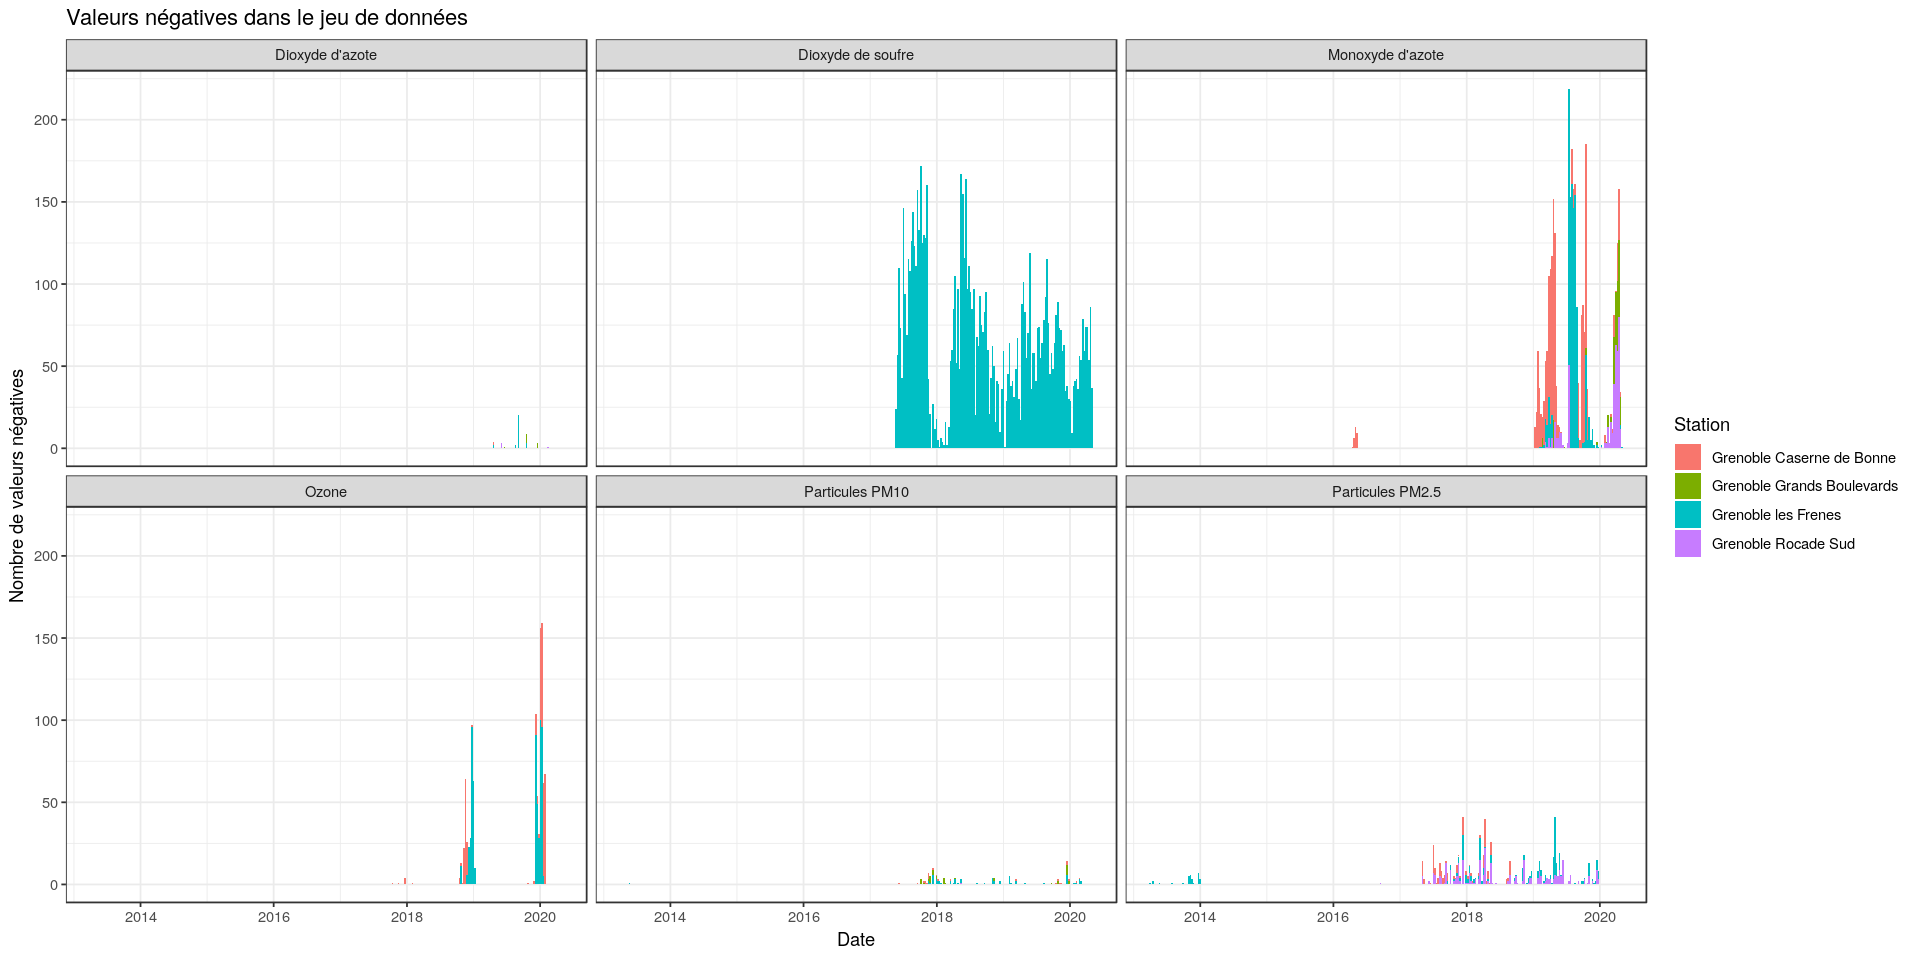

In [8]:
nb_days = as.numeric(max(df$Date) - min(df$Date))
df %>%
    filter(Valeur < 0) %>%
    ggplot() +
    aes(x=Date, fill=Station) +
    facet_wrap("Mesure") +
    geom_histogram(bins=nb_days/10) +
    theme_bw() +
    ylab("Nombre de valeurs négatives") +
    ggtitle("Valeurs négatives dans le jeu de données")

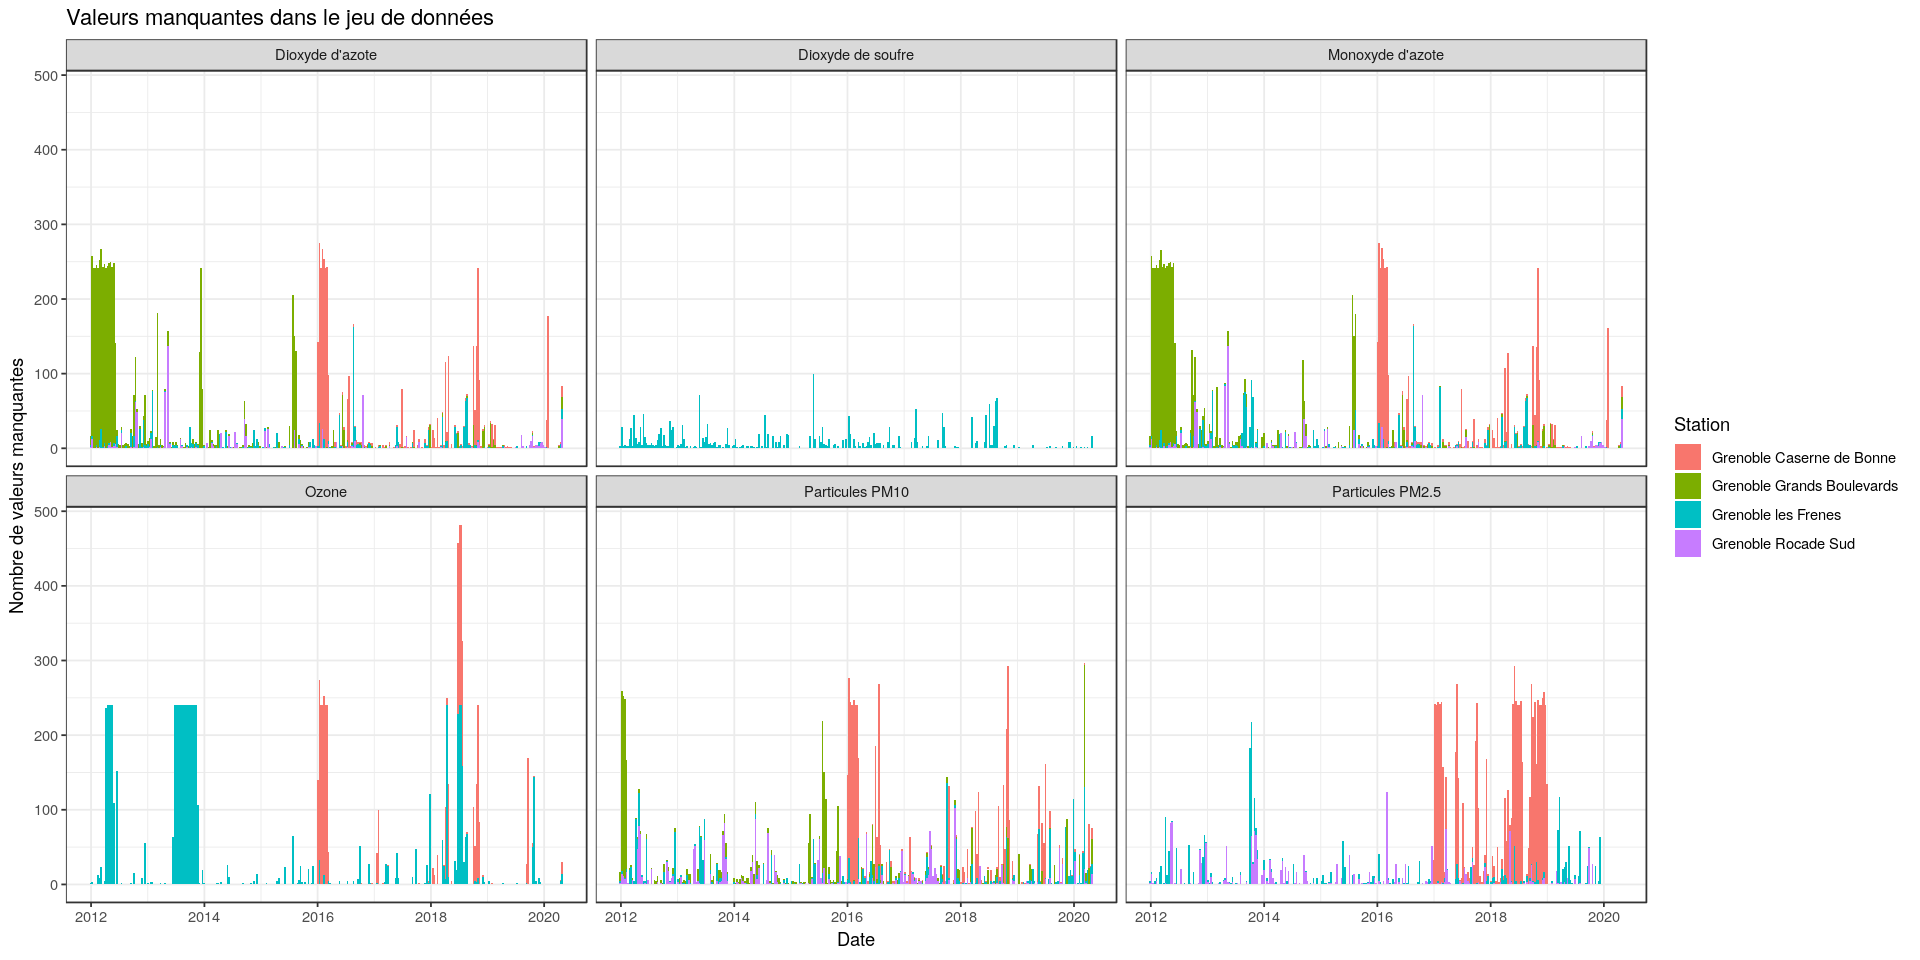

In [9]:
nb_days = as.numeric(max(df$Date) - min(df$Date))
df %>%
    filter(is.na(Valeur)) %>%
    ggplot() +
    aes(x=Date, fill=Station) +
    facet_wrap("Mesure") +
    geom_histogram(bins=nb_days/10) +
    theme_bw() +
    ylab("Nombre de valeurs manquantes") +
    ggtitle("Valeurs manquantes dans le jeu de données")

On peut constater des manques de données sur certaines periodes, pour certaines stations. Cela correspond probablement à des pannes des capteurs. Ça sera à garder en tête par la suite dans les interprétations des courbes. On supprime les entrées avec des données manquantes.

In [10]:
df = df %>% drop_na()

Une première courbe d'évolution, pour visualiser les patterns temporels.

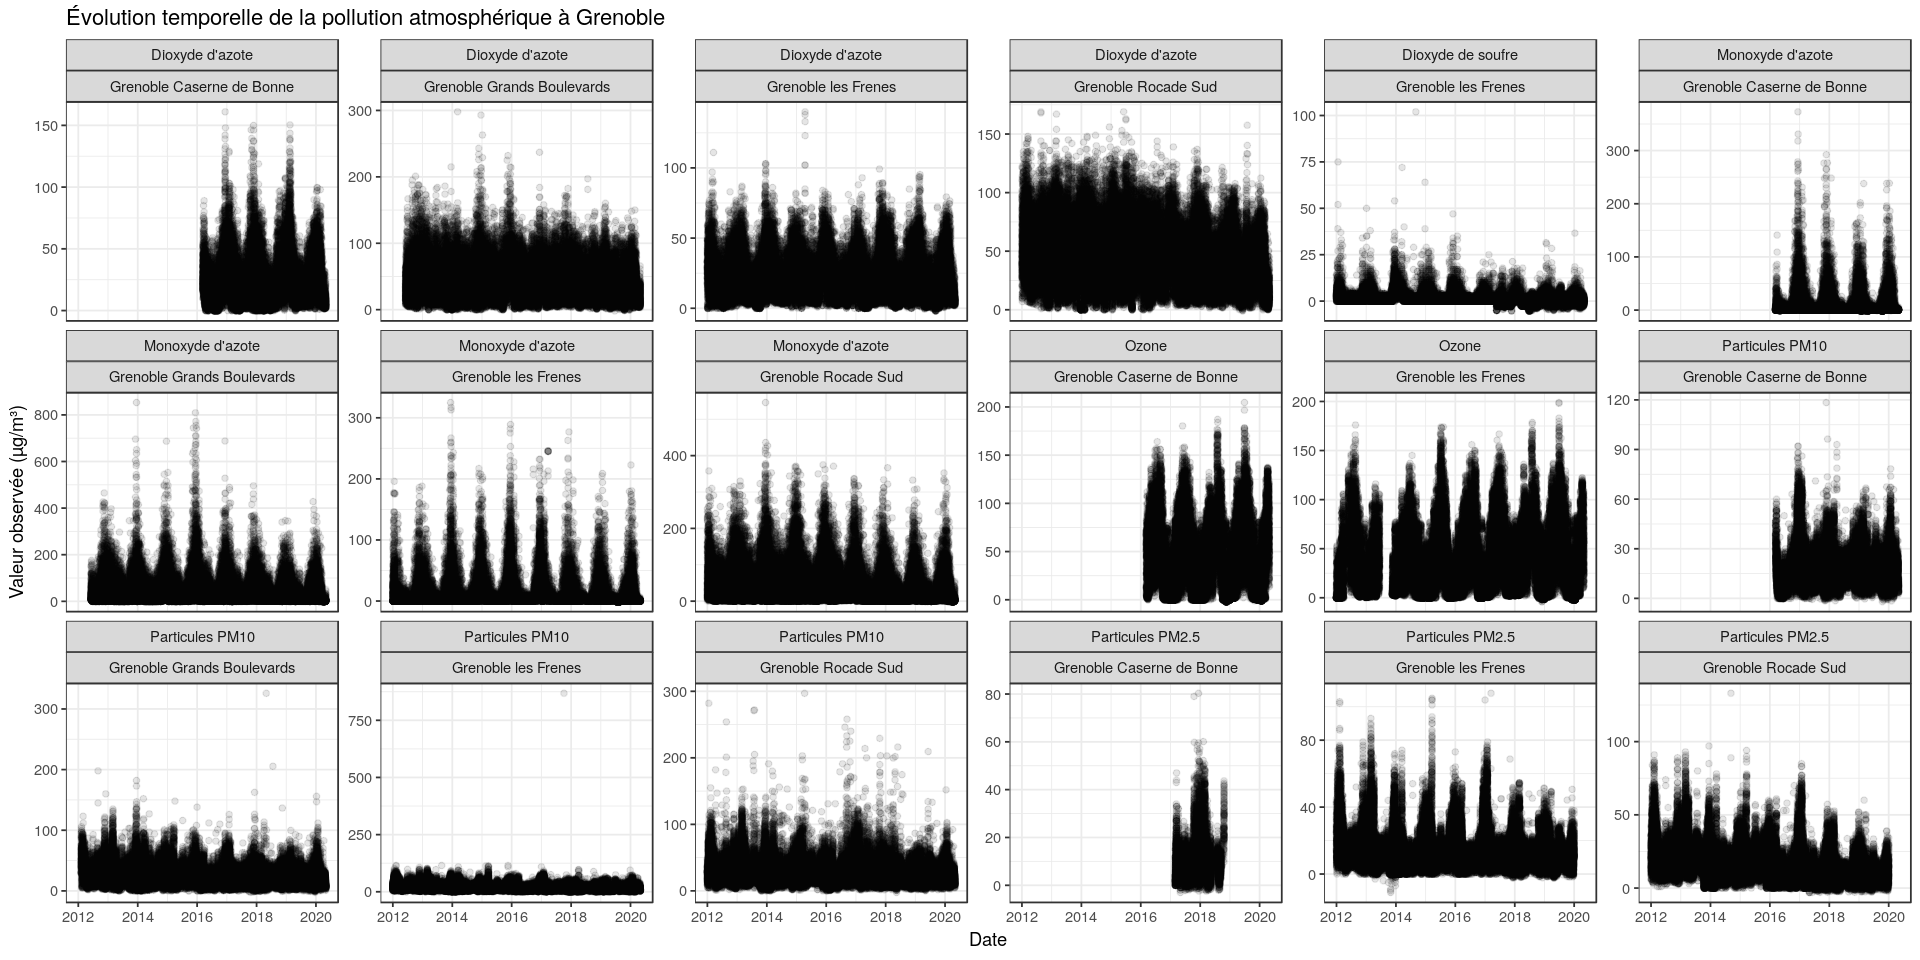

In [11]:
df %>% ggplot() +
    aes(x=Date, y=Valeur) +
    facet_wrap(c("Mesure", "Station"), scales='free_y', nrow=3) +
    geom_point(alpha=0.1) +
    theme_bw() +
    expand_limits(y=0) +
    ylab("Valeur observée (µg/m³)") +
    ggtitle("Évolution temporelle de la pollution atmosphérique à Grenoble")

La station *Grenoble Caserne de Bonne* avait déjà plusieurs pannes pour le capteur PM2.5, on voit sur cette dernière courbe qu'il n'y a carrément plus rien à partir de fin 2018. On va donc supprimer toutes les mesures PM2.5 de cette station.

De même, on supprime l'unique capteur de dioxyde de soufre, qui renvoie de nombreuses valeurs négatives.

In [12]:
df = df %>% filter((Station != "Grenoble Caserne de Bonne") | (Mesure != "Particules PM2.5"))
df = df %>% filter(Mesure != "Dioxyde de soufre")

Enfin, on ajoute diverses variables, comme l'année, le jour, le numéro de jour (entre 1 et 366), le numéro de semaine (entre 1 et 53).

In [13]:
df = df %>% mutate(Annee=year(Date), Mois=month(Date), Jour=day(Date), NumeroJour=yday(Date), NumeroSemaine=week(Date), Instant=parse_date_time(format(Date, format="%m/%d %H:%M"), "mdhM"))

## Analyse des données

Il y a beaucoup de variabilité dans les données, il est difficile de voir quelque chose. Pour "lisser" tout ça, on prend une moyenne roulante sur 7 jours.

In [14]:
width = 24*7
df = df %>%
    group_by(Station, Mesure) %>%
    mutate(avg=rollapply(Valeur, width, mean, fill=NA)) %>%
    drop_na() %>%
    ungroup()

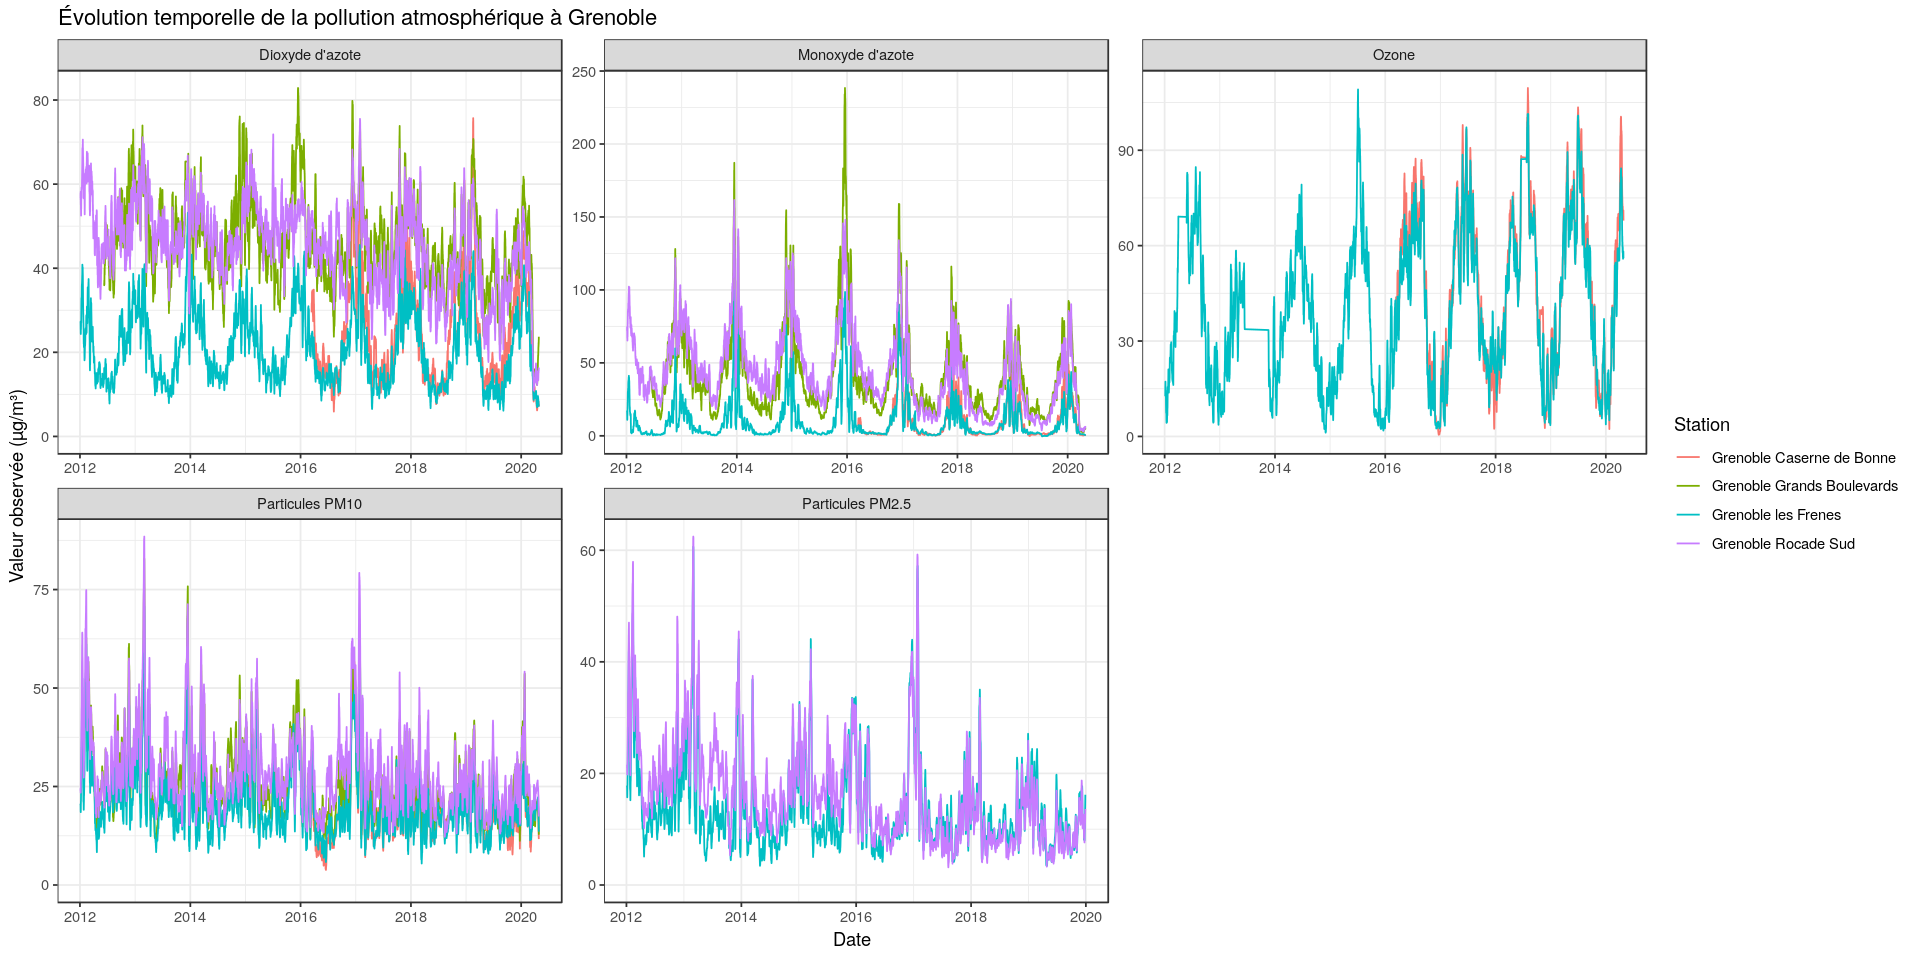

In [15]:
df %>%
    ggplot() +
    aes(x=Date, y=avg, color=Station) +
    facet_wrap(c("Mesure"), scales='free') +
    geom_line() +
    theme_bw() +
    expand_limits(y=0) +
    ylab("Valeur observée (µg/m³)") +
    ggtitle("Évolution temporelle de la pollution atmosphérique à Grenoble")

On va maintenant regarder si le confinement (qui a débuté officiellement le 17 mars 2020 à 12h) à un quelconque effet.

In [16]:
max_numero_semaine = df %>% filter(Annee == 2020) %>% select(NumeroSemaine) %>% max()
max_numero_semaine

[1] 17

In [17]:
df = df %>%
    mutate(Confinement = Date >= parse_date_time("17/03/2020 12:00", "dmyhM"))

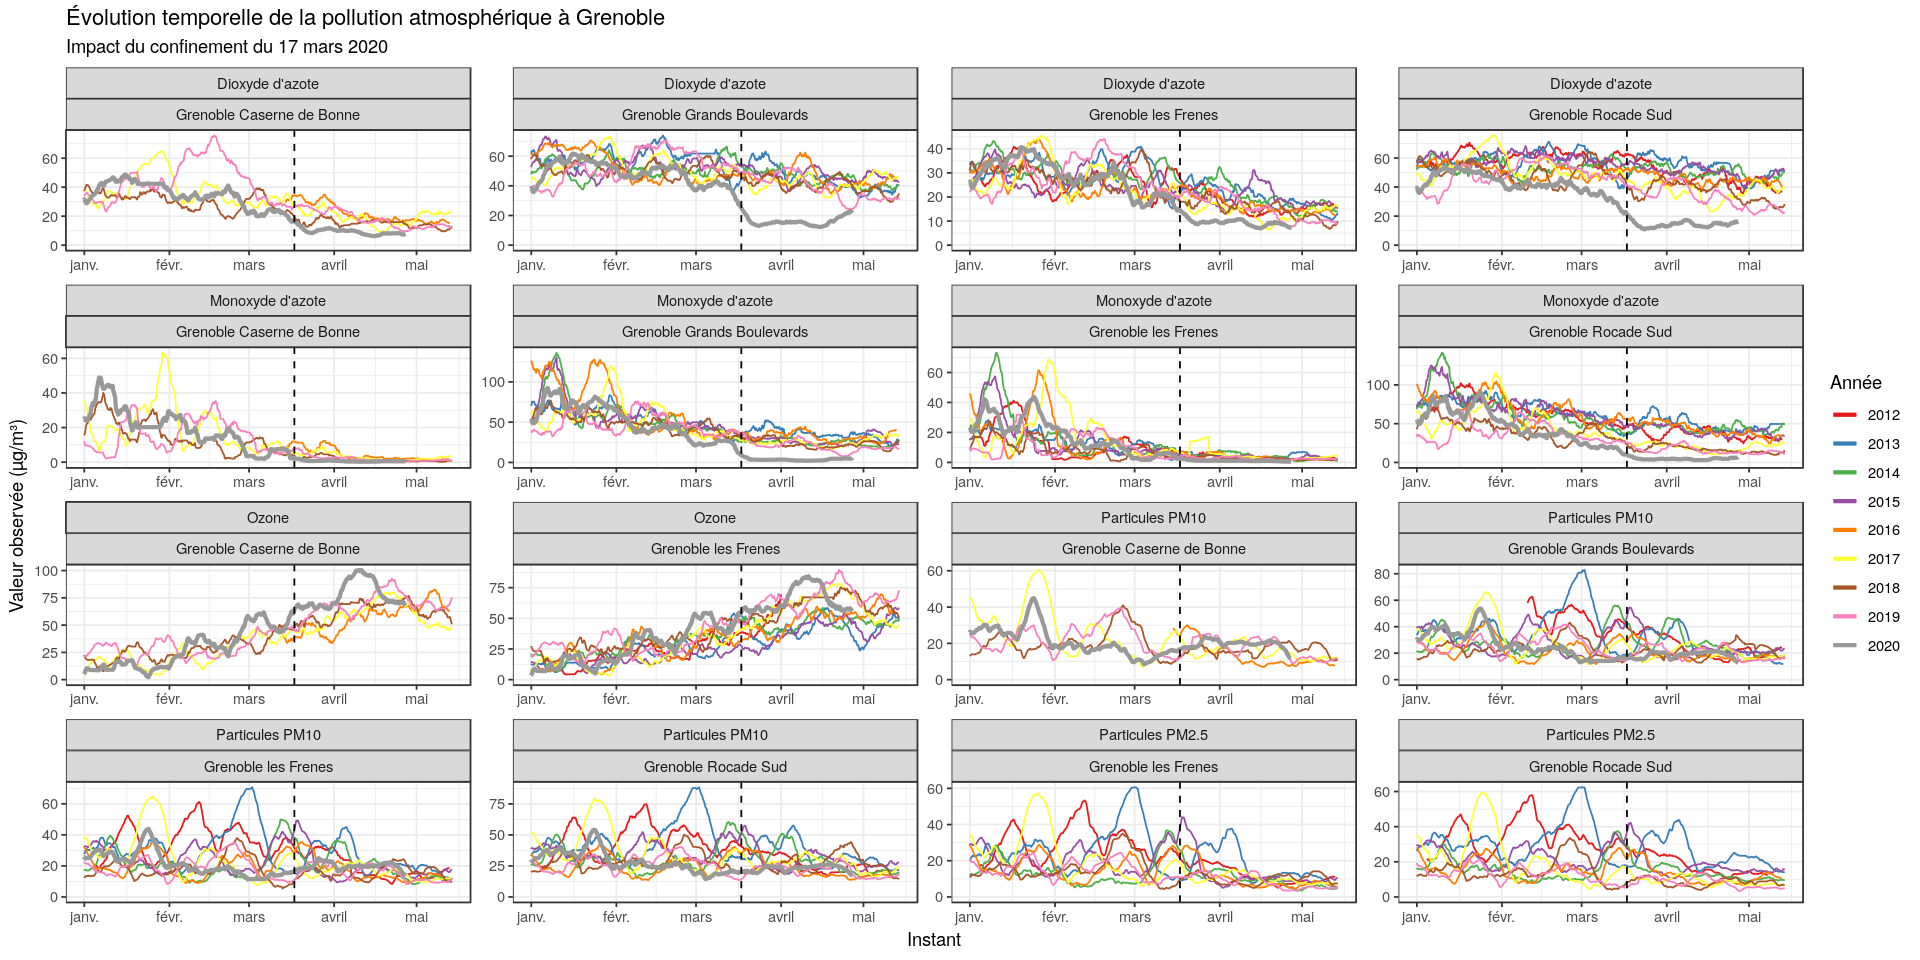

In [18]:
df %>%
    filter(NumeroSemaine < max_numero_semaine + 3) %>% {
    ggplot(.) +
    aes(x=Instant, y=avg, color=factor(Annee)) +
    facet_wrap(c("Mesure", "Station"), scales='free') +
    geom_line() +
    geom_line(data=filter(., Annee == 2020), size=1.2) +
    theme_bw() +
    expand_limits(y=0) +
    scale_colour_brewer(palette = "Set1") +
    geom_vline(xintercept=parse_date_time("17/03 12:00", "dmhM"), linetype='dashed') +
    ylab("Valeur observée (µg/m³)") +
    labs(color='Année') +
    ggtitle("Évolution temporelle de la pollution atmosphérique à Grenoble") +
    labs(subtitle="Impact du confinement du 17 mars 2020")
}

In [19]:
df %>%
    filter(NumeroSemaine < max_numero_semaine + 3, Station == "Grenoble les Frenes", Mesure == "Particules PM2.5") %>% {
    ggplot(.) +
    aes(x=Instant, y=avg, color=factor(Annee)) +
    geom_line() +
    geom_line(data=filter(., Annee == 2020), size=2) +
    theme_bw() +
    expand_limits(y=0) +
    scale_colour_brewer(palette = "Set1") +
    geom_vline(xintercept=parse_date_time("17/03 12:00", "dmhM"), linetype='dashed') +
    ylab("Valeur observée (µg/m³)") +
    labs(color='Année') +
    ggtitle("Évolution temporelle du taux de particules PM2.5 à Grenoble") +
    labs(subtitle="Station Grenoble les Frenes, données Atmo Aura")
}

Visuellement, le confinement (représenté par la ligne verticale en pointillés) semble avoir réduit les concentrations de dioxyde d'azote et de monoxyde d'azote. Il ne semble pas y avoir d'effet sur les concentrations d'ozone et de particules fines (PM10 et PM2.5). On va maintenant calculer le pourcentage de diminution (ou augmentation) entre 2020 et la moyenne des trois autres années, pour chacune des 14 premières semaines.

Warning message:
“Removed 16 rows containing missing values (geom_path).”Warning message:
“Removed 16 rows containing missing values (geom_point).”

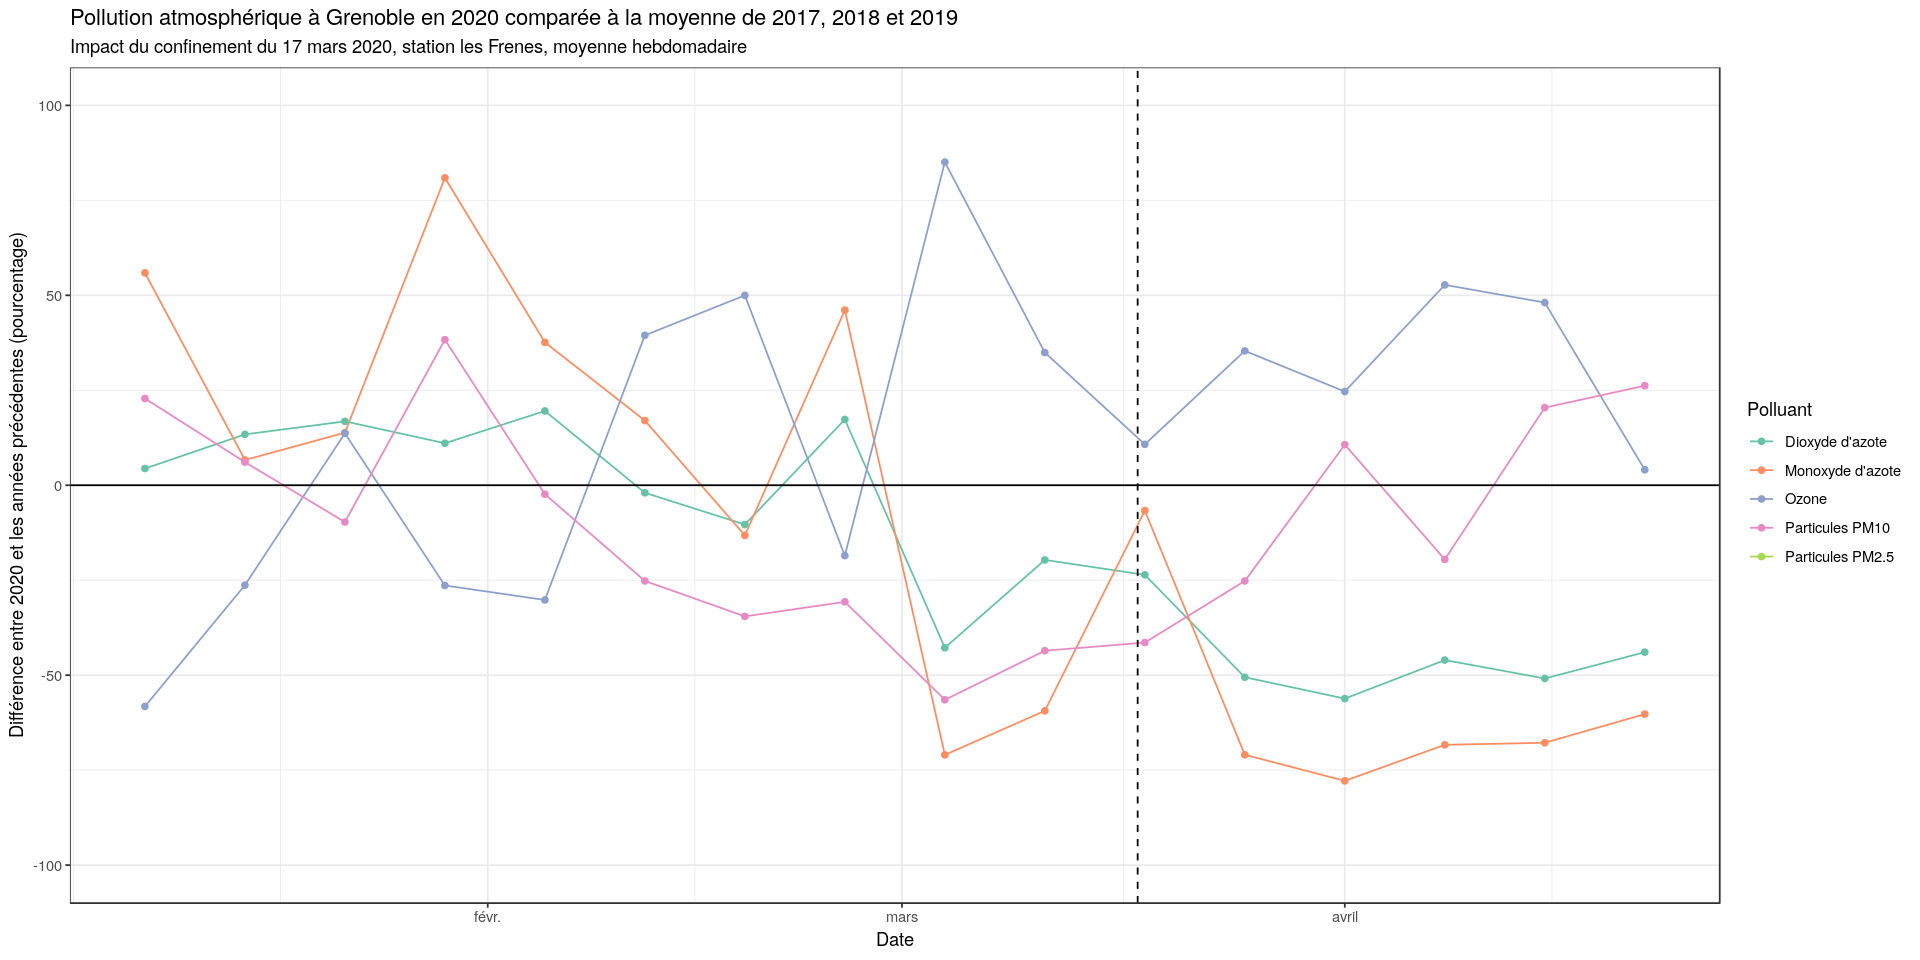

In [20]:
df_old = df %>% filter(Station == "Grenoble les Frenes", Annee <= 2019, NumeroSemaine < max_numero_semaine) %>% group_by(Mesure, NumeroSemaine) %>% summarise(avg=mean(Valeur))
df_new = df %>% filter(Station == "Grenoble les Frenes", Annee == 2020, NumeroSemaine < max_numero_semaine) %>% group_by(Mesure, NumeroSemaine) %>% summarise(avg=mean(Valeur))
df_old %>%
    full_join(df_new, by=c("Mesure", "NumeroSemaine"), suffix=c("_old", "_new")) %>%
    mutate(ratio = (avg_new-avg_old)/avg_old*100) %>%
    ungroup() %>%
    mutate(Date=parse_date_time("01-01", "md") + lubridate::weeks(NumeroSemaine)) %>%
    ggplot() +
    aes(x=Date, y=ratio, color=Mesure) +
    geom_line() +
    geom_point() +
    geom_vline(xintercept=parse_date_time("17/03 12:00", "dmhM"), linetype='dashed') +
    geom_hline(yintercept = 0) +
    theme_bw() +
    scale_colour_brewer(palette = "Set2") +
    expand_limits(y=c(-100, +100)) +
    labs(color="Polluant") +
    ylab("Différence entre 2020 et les années précédentes (pourcentage)") +
    ggtitle("Pollution atmosphérique à Grenoble en 2020 comparée à la moyenne de 2017, 2018 et 2019") +
    labs(subtitle="Impact du confinement du 17 mars 2020, station les Frenes, moyenne hebdomadaire")

Regardons les particules fines plus en détail :

 num 1.96


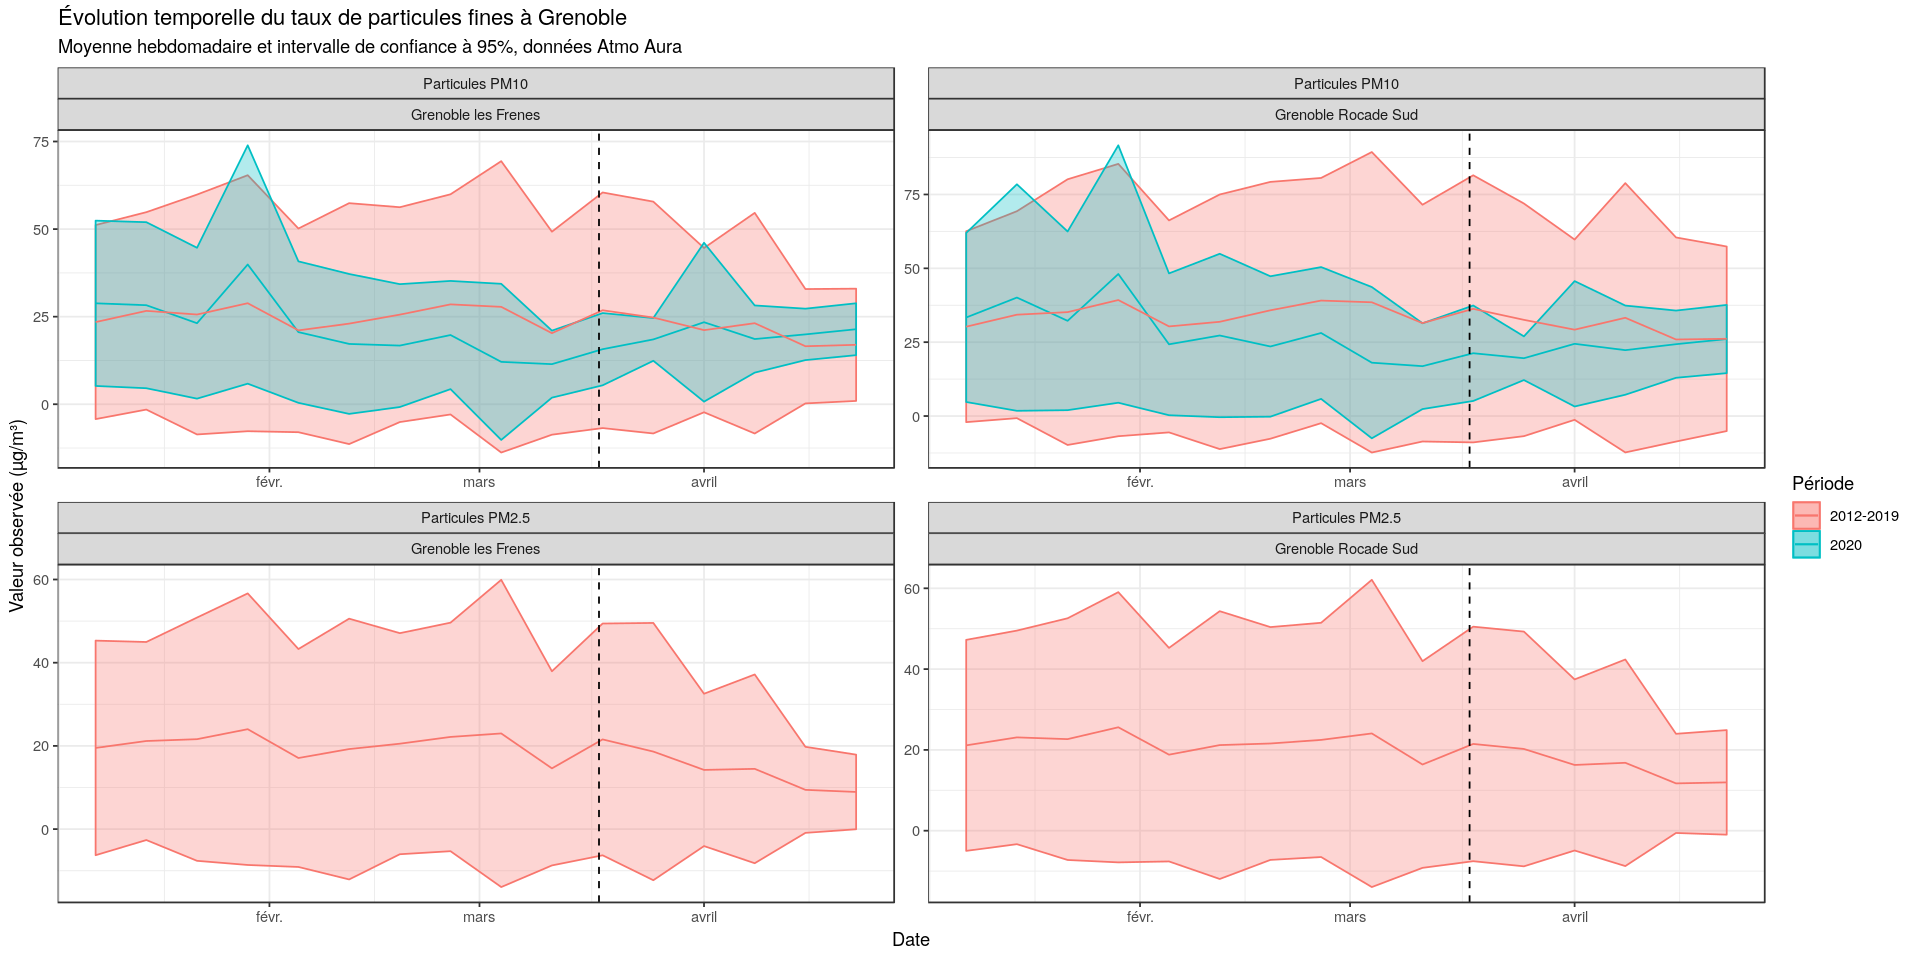

In [21]:
summarise_data = function(data) {
    return(data %>%
        filter(Mesure %in% c("Particules PM2.5", "Particules PM10"), Station %in% c("Grenoble les Frenes", "Grenoble Rocade Sud"), NumeroSemaine < max_numero_semaine) %>%
        group_by(Mesure, Station, NumeroSemaine) %>%
        summarise(avg=mean(Valeur), std=sd(Valeur), vmin=min(Valeur), vmax=max(Valeur), q25=quantile(Valeur, 0.25), q75=quantile(Valeur, 0.75)) %>%
        mutate(Date=parse_date_time("01-01", "md") + lubridate::weeks(NumeroSemaine))
    )
}
df_old = summarise_data(df %>% filter(Annee <= 2019)) %>% mutate(Periode = "2012-2019")
df_new = summarise_data(df %>% filter(Annee == 2020)) %>% mutate(Periode = "2020")

confidence = 0.95
coeff = qnorm(1-(1-confidence)/2)
str(coeff)

ggplot() +
    aes(x=Date, y=avg, color=Periode, fill=Periode) +
    geom_ribbon(data=df_old, aes(ymin=avg-coeff*std, ymax=avg+coeff*std), alpha=0.3) +
    geom_ribbon(data=df_new, aes(ymin=avg-coeff*std, ymax=avg+coeff*std), alpha=0.3) +
    facet_wrap(c("Mesure", "Station"), scales='free') +
    geom_line(data=df_new) +
    geom_line(data=df_old) +
    geom_vline(xintercept=parse_date_time("17/03 12:00", "dmhM"), linetype='dashed') +
    expand_limits(y=0) +
    theme_bw() +
    labs(color="Période", fill="Période") +
    ylab("Valeur observée (µg/m³)") +
    ggtitle("Évolution temporelle du taux de particules fines à Grenoble") +
    labs(subtitle="Moyenne hebdomadaire et intervalle de confiance à 95%, données Atmo Aura")

In [22]:
df %>%
    filter(NumeroSemaine < max_numero_semaine+3, Station == "Grenoble les Frenes") %>% {
    ggplot(.) +
    aes(x=Instant, y=avg, color=factor(Annee)) +
    geom_line() +
    geom_line(data=filter(., Annee == 2020), size=2) +
    theme_bw() +
    expand_limits(y=0) +
    facet_wrap(c("Mesure", "Station"), scales='free') +
    scale_colour_brewer(palette = "Set1") +
    geom_vline(xintercept=parse_date_time("17/03 12:00", "dmhM"), linetype='dashed') +
    ylab("Valeur observée (µg/m³)") +
    labs(color='Année') +
    ggtitle("Évolution temporelle du taux de polluants à Grenoble") +
    labs(subtitle="Station Grenoble les Frenes, données Atmo Aura")
}

In [23]:
plot_bivariate <- function(df, x_col, y_col, group_col) {
    density_plot = ggplot(df) +
        aes_string(color=group_col) +
        geom_density() +
        theme_void() +
        theme(legend.position="none")

    plot_top = density_plot + aes_string(x=x_col)
    plot_right = density_plot + aes_string(x=y_col) + coord_flip()

    cor_val = cor(df[[x_col]], df[[y_col]])
    str(paste("Correlation de", round(cor_val, 2), "entre les taux de", x_col, "et", y_col))

    scatter_plot = ggplot(df) +
        aes_string(x=x_col, y=y_col, color=group_col) +
        geom_point(alpha=0.1) +
        stat_ellipse() +
        theme_minimal() +
        xlab(paste(x_col, "(µg/m³)")) +
        ylab(paste(y_col, "(µg/m³)")) +
        labs(color="Période")

    plot = plot_top + guide_area() + scatter_plot + plot_right +
        plot_annotation(title="Corrélation entre polluants atmosphériques", subtitle="Station Grenoble les Frenes de 2012 à 2019 (données @atmo_aura)") +
        plot_layout(widths = c(3, 1), heights = c(1, 3)) +
        plot_layout(guides = 'collect') &
        scale_colour_brewer(palette = "Set1")

    return(plot)
}

Pour la station *Grenoble les Frenes*, on a une valeur anormalement élevée pour les PM10 le 05/10/2017 à 1h. En effet, on a un taux de 868µg/m³ alors que le second taux le plus élevé est de 115µg/m³. On va donc supprimer cette mesure qui nuit à la lisibilité des courbes suivantes.

In [24]:
df %>% filter(Station == "Grenoble les Frenes", Mesure == "Particules PM10", Valeur > 110) %>% arrange(-Valeur)

Station             Polluant        Mesure          Unité    
1 Grenoble les Frenes Particules PM10 Particules PM10 microg/m3
2 Grenoble les Frenes Particules PM10 Particules PM10 microg/m3
3 Grenoble les Frenes Particules PM10 Particules PM10 microg/m3
4 Grenoble les Frenes Particules PM10 Particules PM10 microg/m3
5 Grenoble les Frenes Particules PM10 Particules PM10 microg/m3
6 Grenoble les Frenes Particules PM10 Particules PM10 microg/m3
7 Grenoble les Frenes Particules PM10 Particules PM10 microg/m3
8 Grenoble les Frenes Particules PM10 Particules PM10 microg/m3
  raw_date         Valeur Date                Annee Mois Jour NumeroJour
1 05.10.2017.1.00  868.1  2017-10-05 01:00:00 2017  10    5   278       
2 09.02.2012.23.00 115.0  2012-02-09 23:00:00 2012   2    9    40       
3 23.08.2013.11.00 115.0  2013-08-23 11:00:00 2013   8   23   235       
4 17.11.2015.9.00  115.0  2015-11-17 09:00:00 2015  11   17   321       
5 09.02.2012.22.00 114.0  2012-02-09 22:00:00 2012   2    9    40       
6 20.03.2015.22.00 114.0  2015-03-20 22:00:00 2015   3   20    79       
7 16.02.2015.11.00 113.0  2015-02-16 11:00:00 2015   2   16    47       
8 20.03.2015.23.00 111.0  2015-03-20 23:00:00 2015   3   20    79       
  NumeroSemaine Instant          avg      Confinement
1 40            0-10-05 01:00:00 25.76190 FALSE      
2  6            0-02-09 23:00:00 55.45833 FALSE      
3 34            0-08-23 11:00:00 21.01190 FALSE      
4 46            0-11-17 09:00:00 37.25000 FALSE      
5  6            0-02-09 22:00:00 55.31548 FALSE      
6 12            0-03-20 22:00:00 42.01786 FALSE      
7  7            0-02-16 11:00:00 29.47024 FALSE      
8 12            0-03-20 23:00:00 41.97619 FALSE

 chr "Correlation de 0.58 entre les taux de NO2 et NO"
 chr "Correlation de -0.64 entre les taux de NO2 et O3"


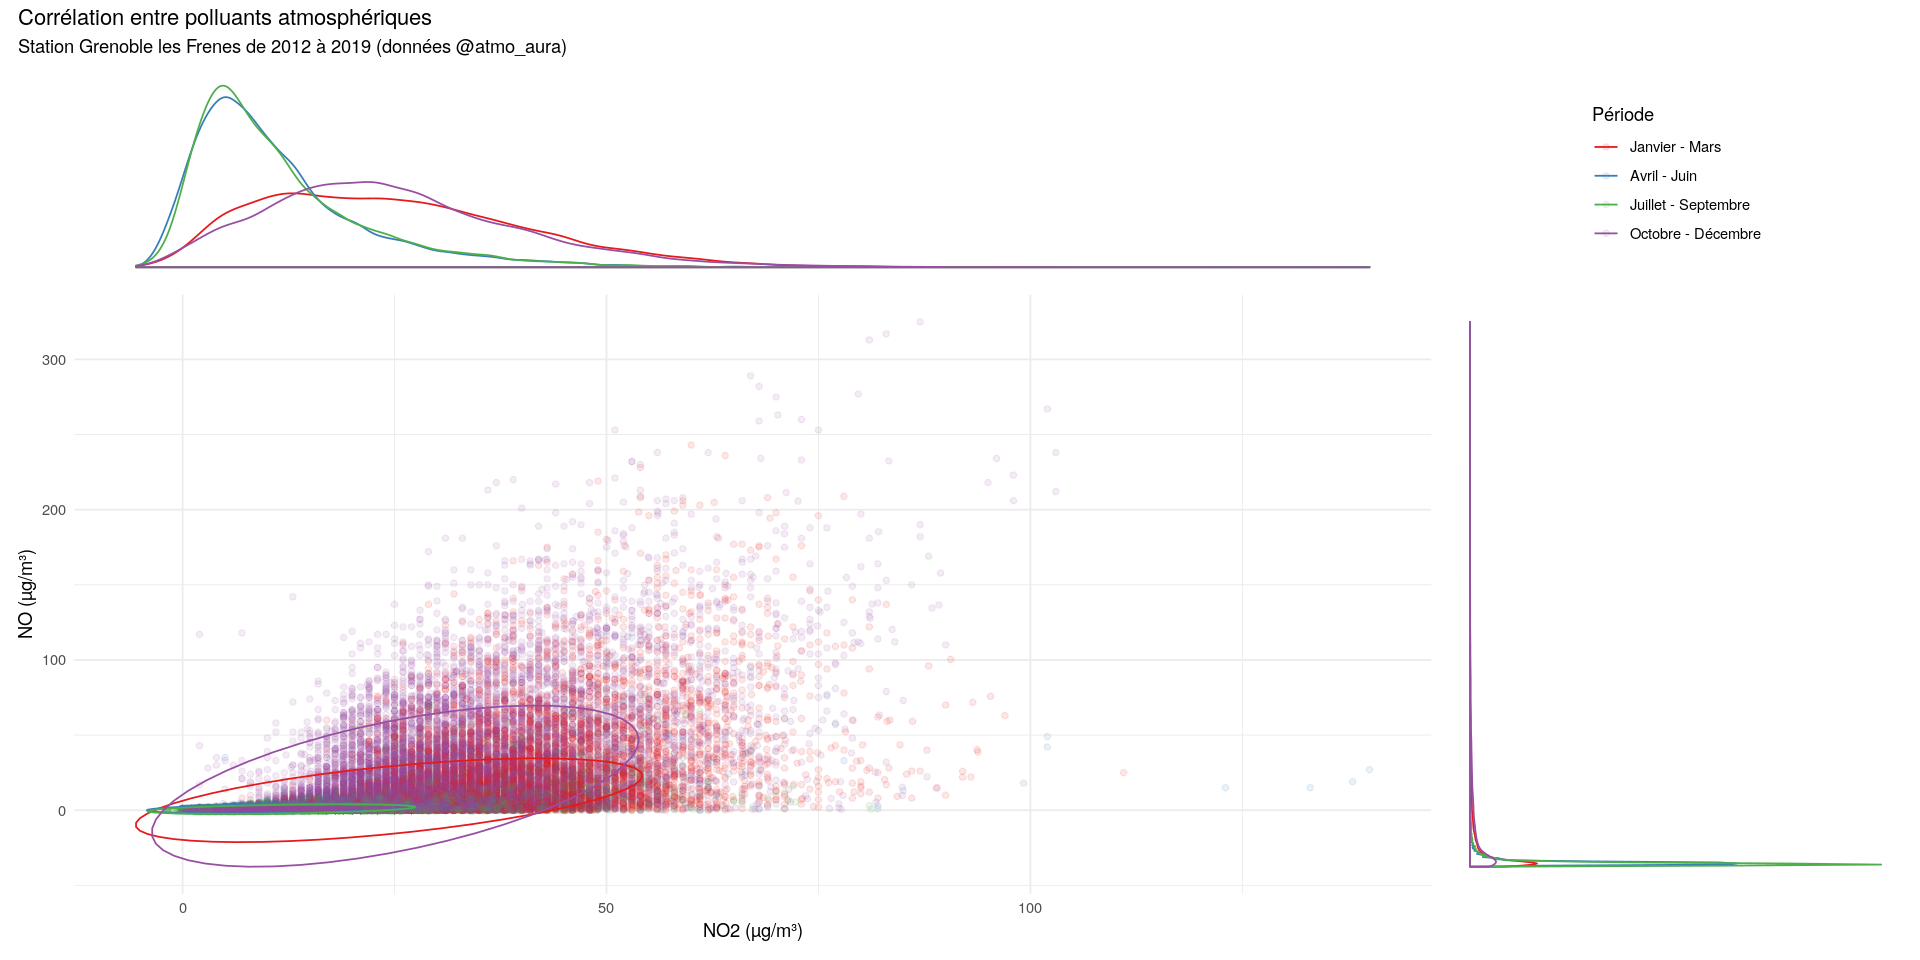

 chr "Correlation de 0.52 entre les taux de NO2 et PM10"


 chr "Correlation de 0.51 entre les taux de NO2 et PM2.5"


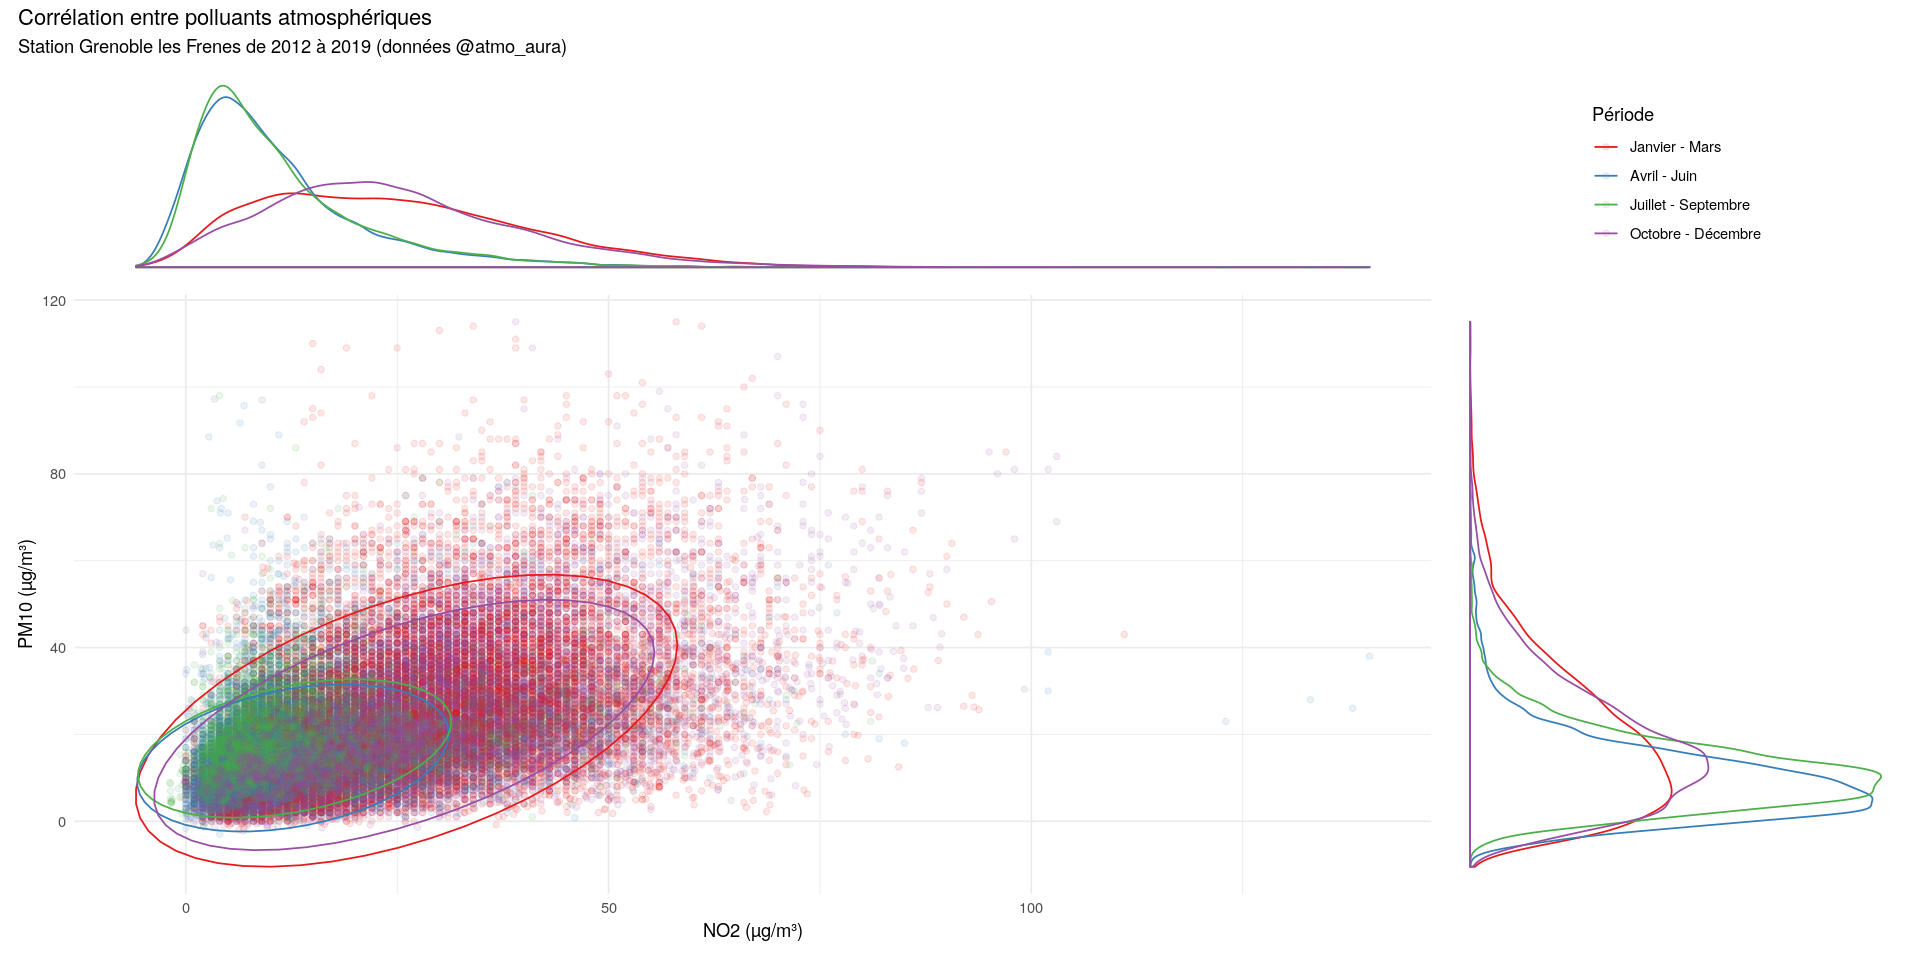

 chr "Correlation de -0.44 entre les taux de NO et O3"


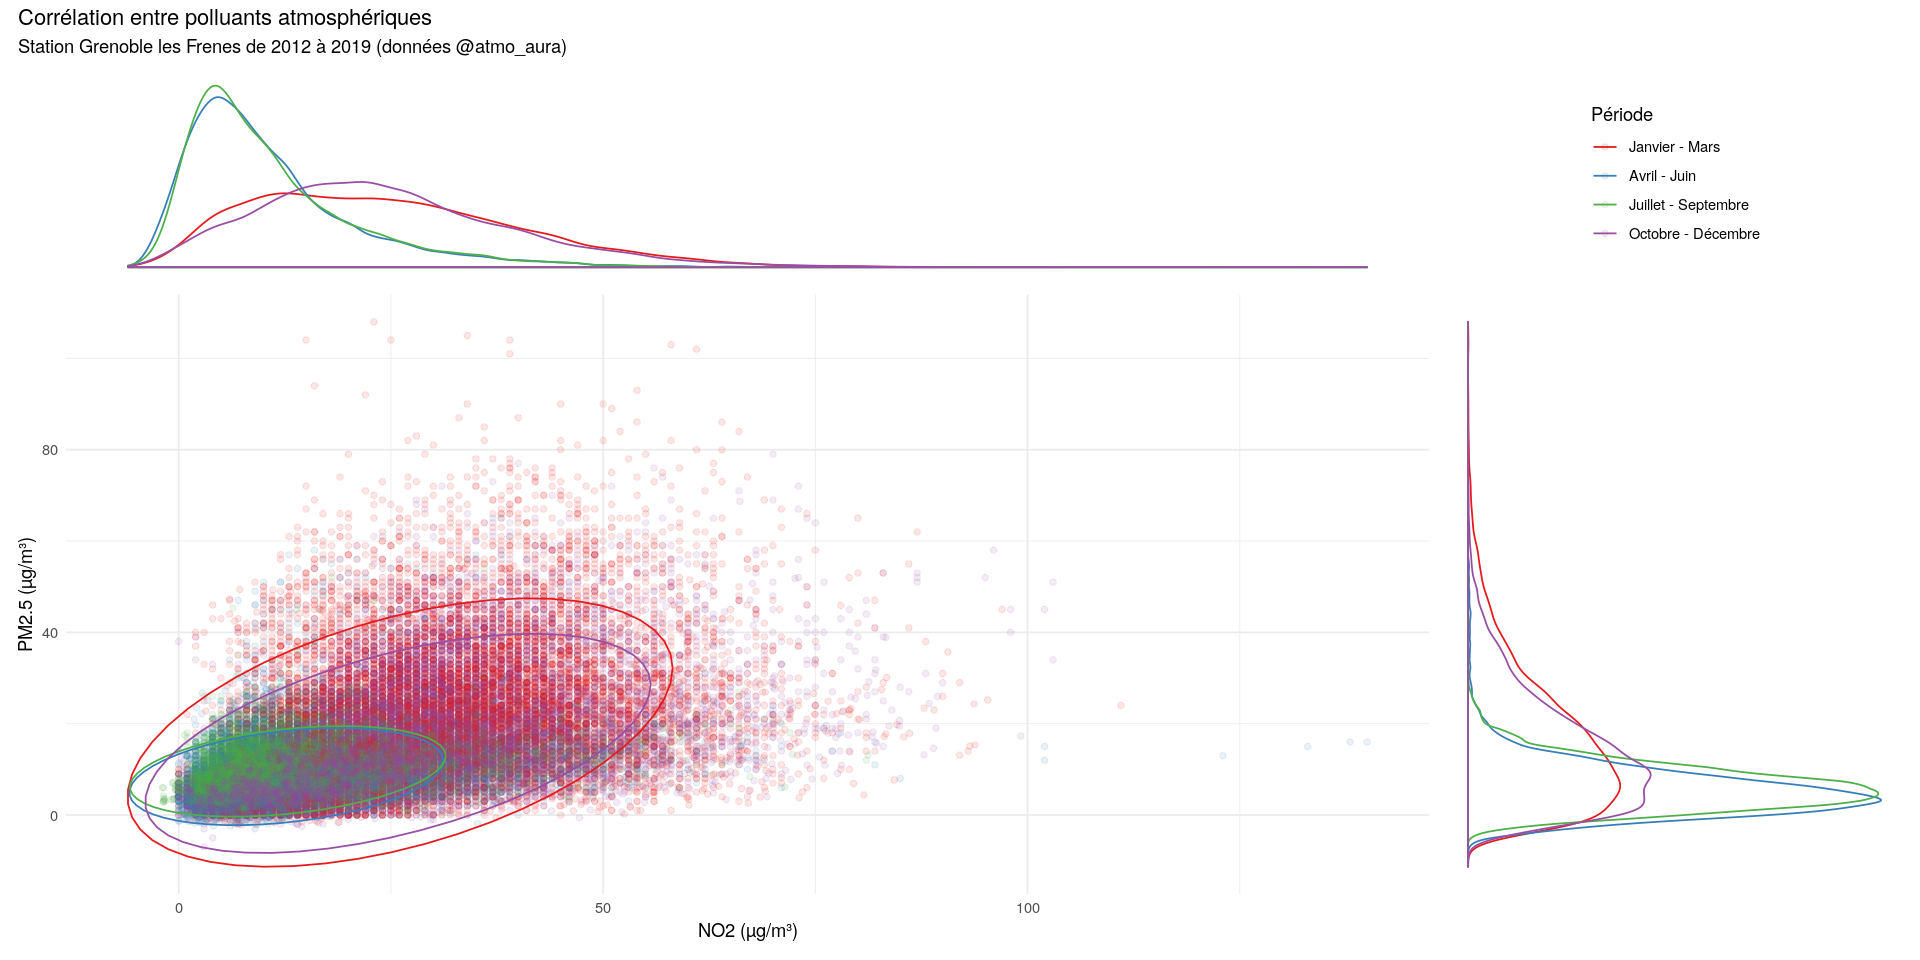

 chr "Correlation de 0.51 entre les taux de NO et PM10"


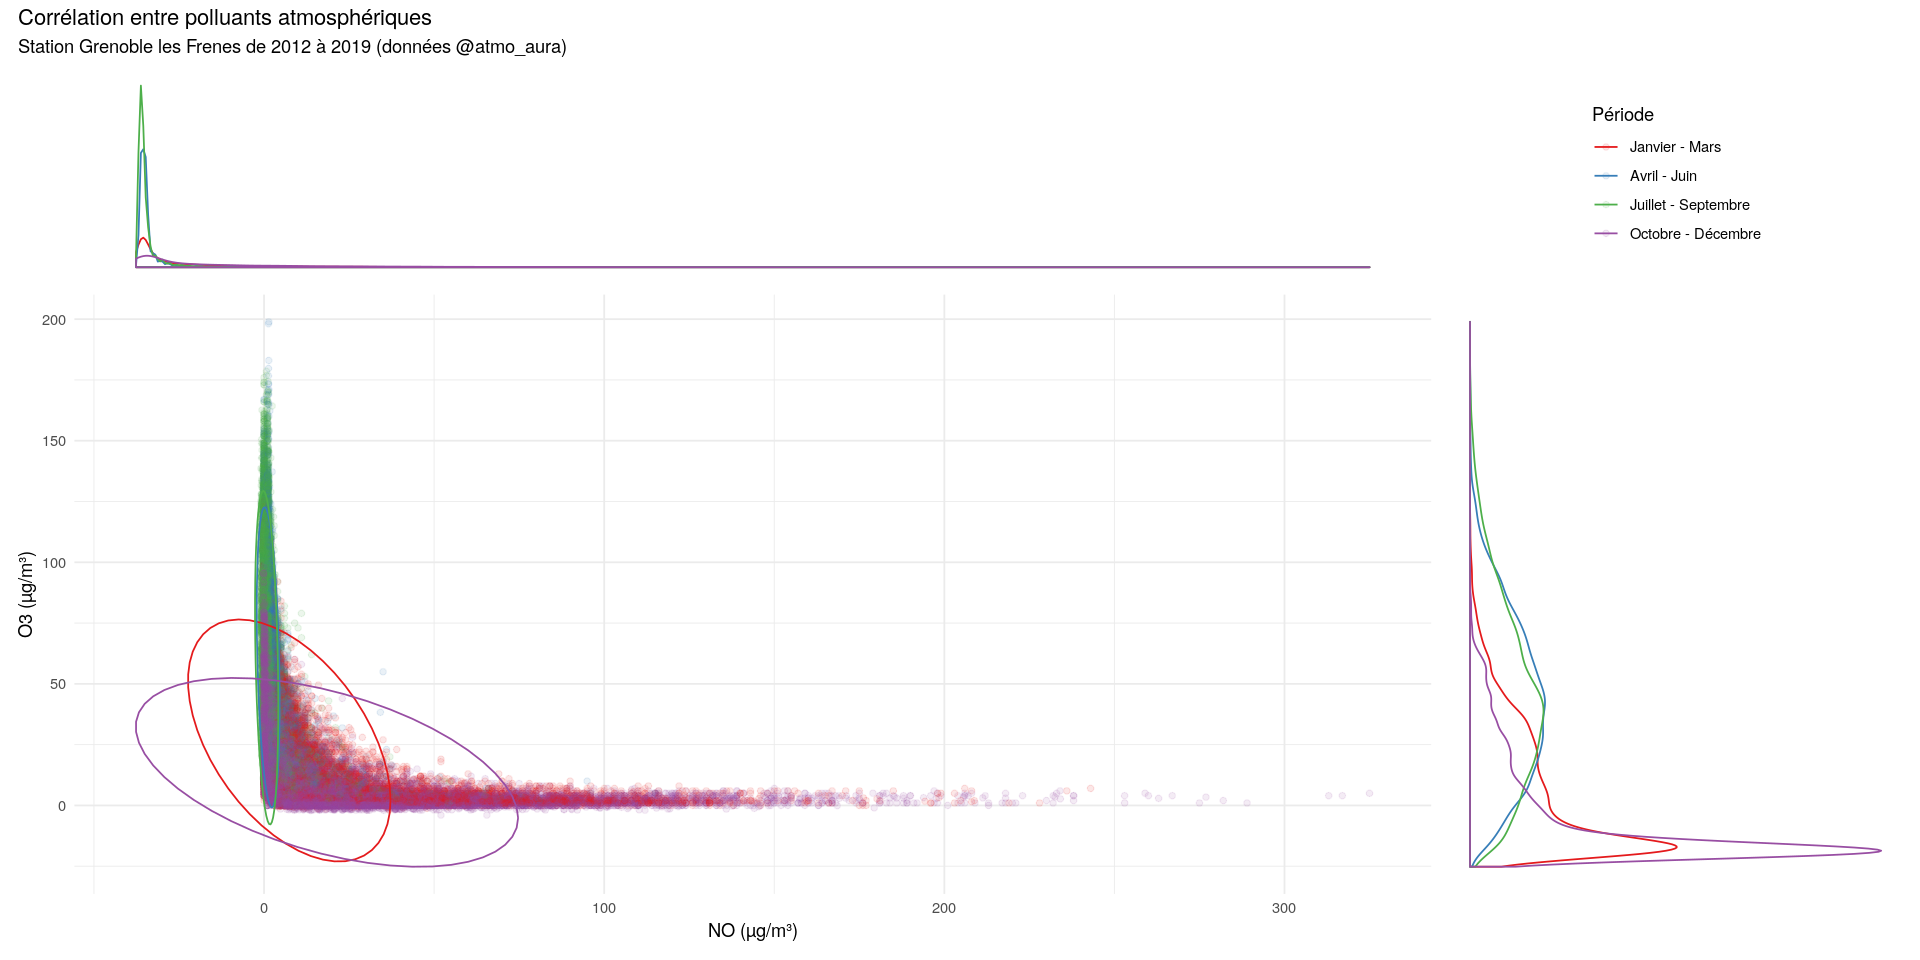

 chr "Correlation de 0.51 entre les taux de NO et PM2.5"


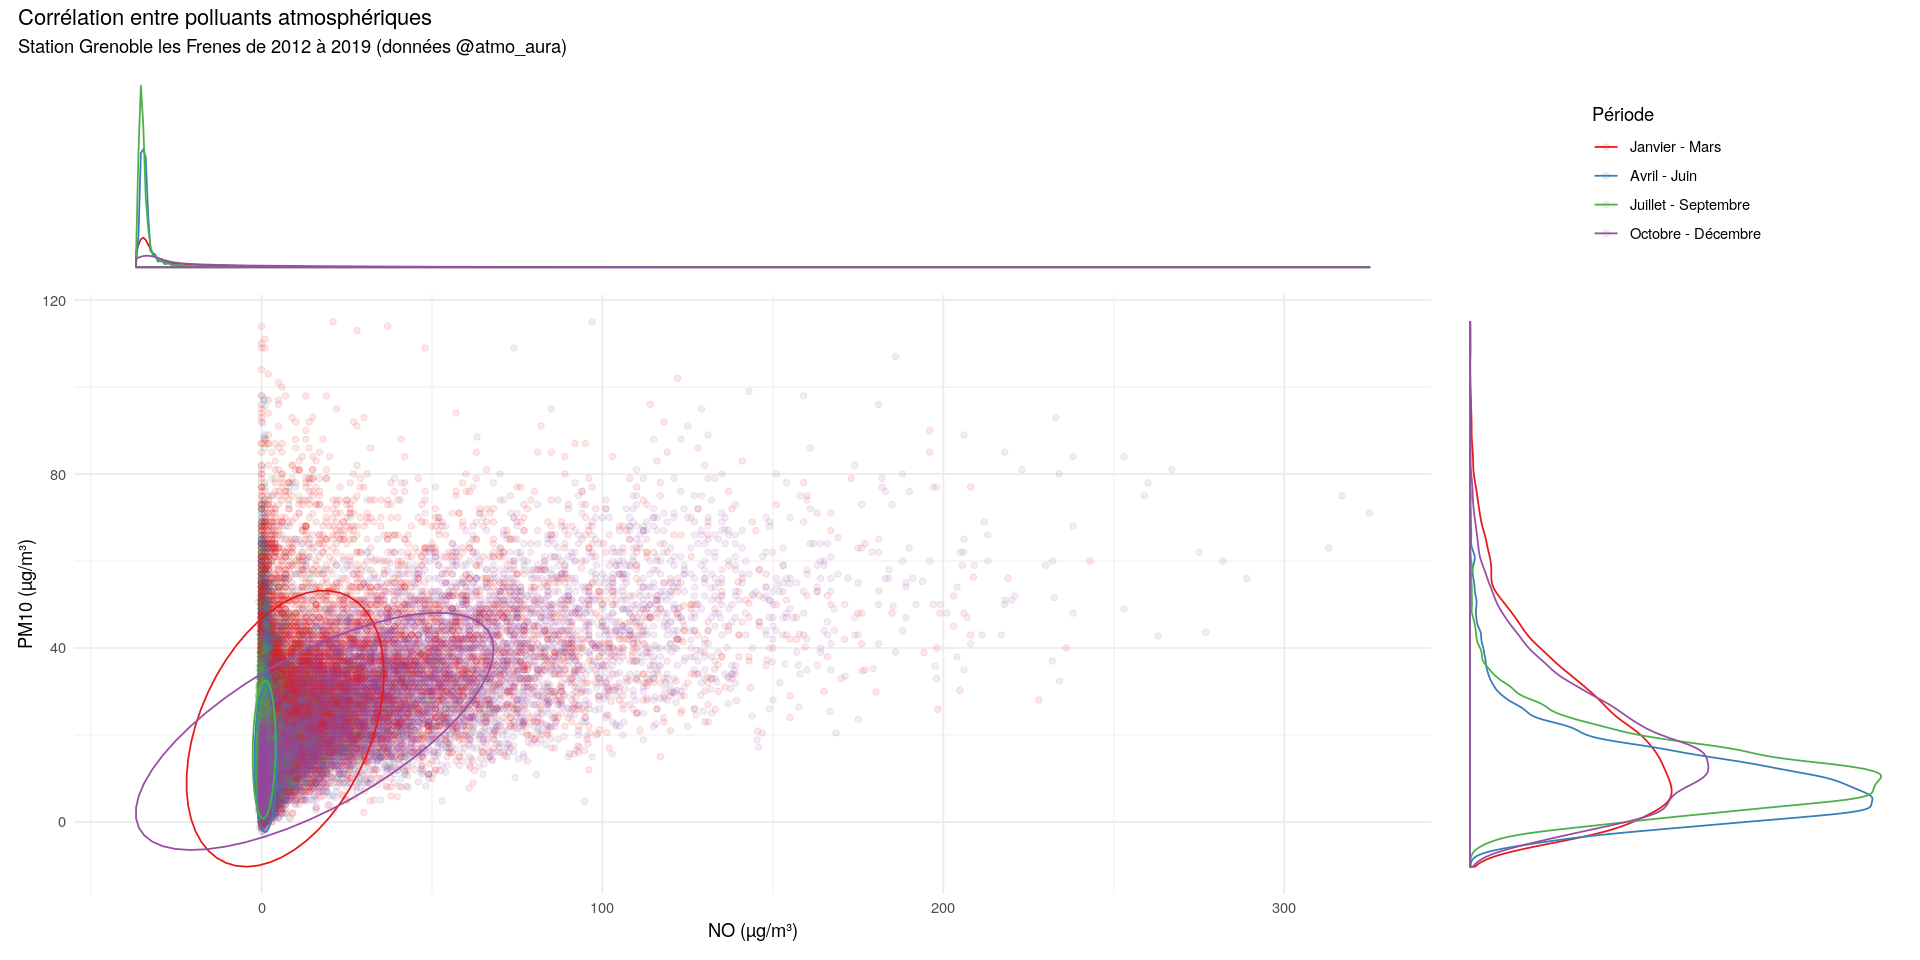

 chr "Correlation de -0.28 entre les taux de O3 et PM10"


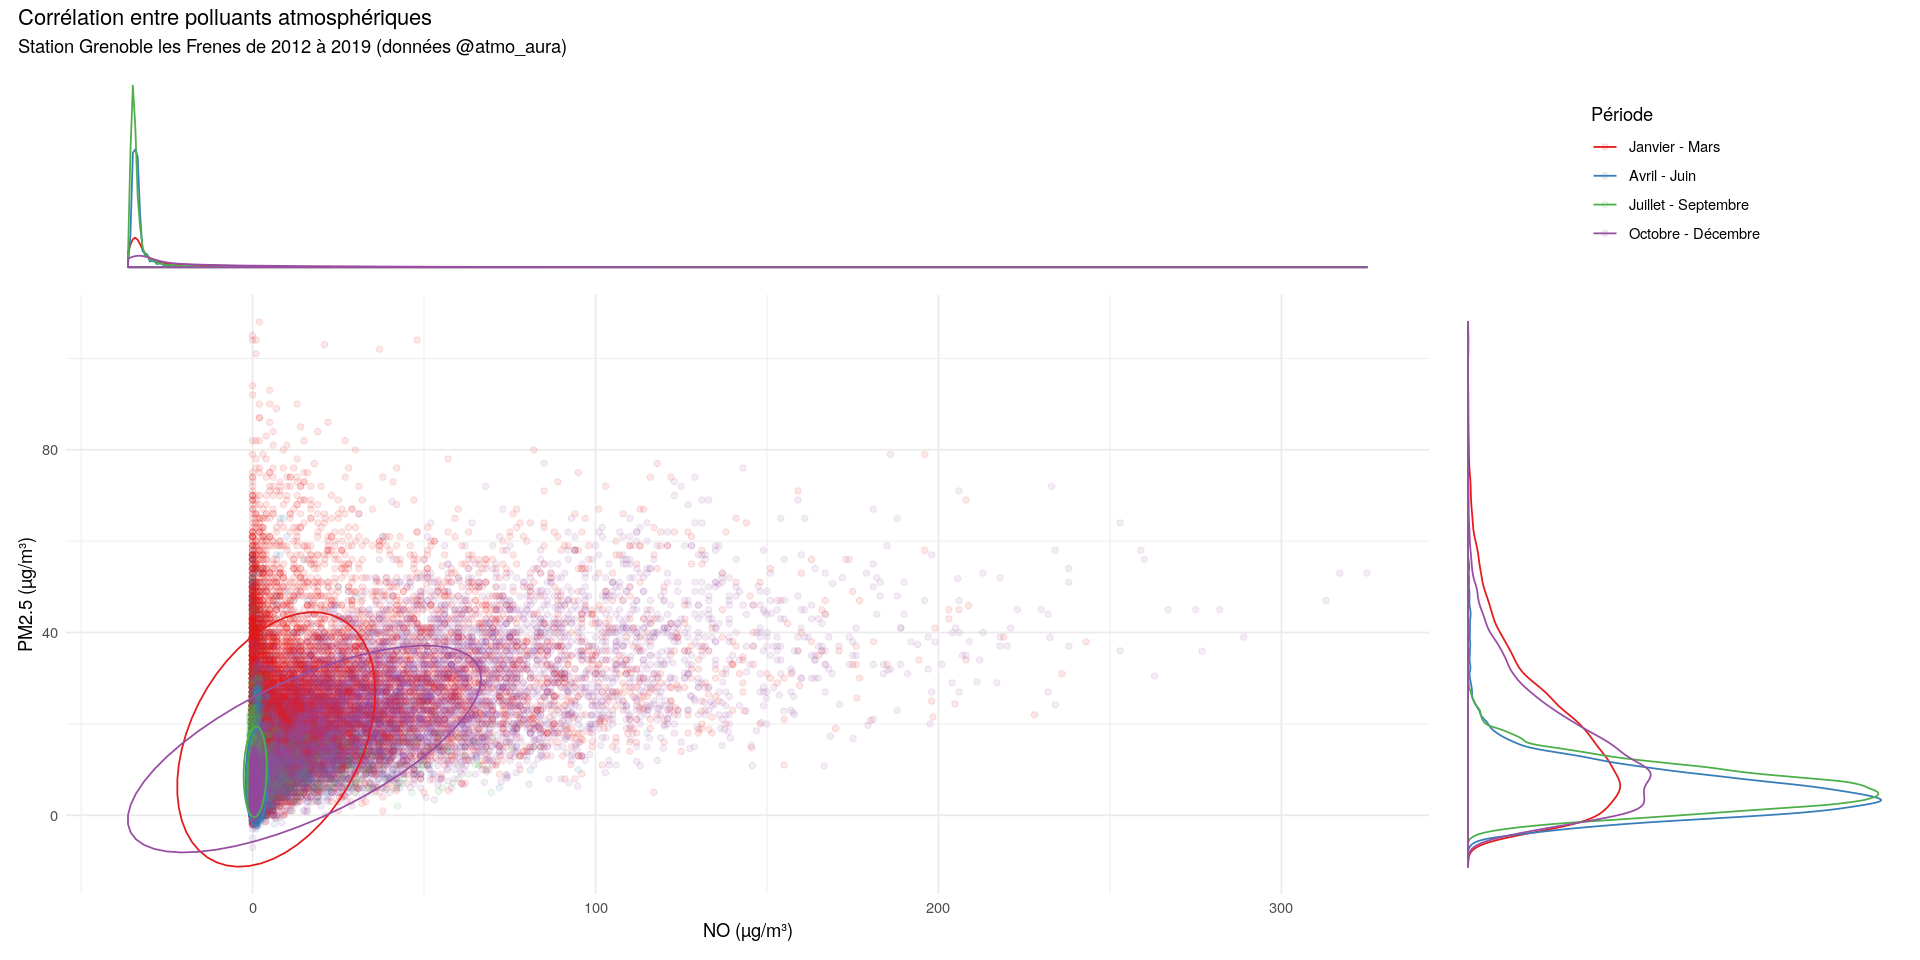

 chr "Correlation de -0.39 entre les taux de O3 et PM2.5"


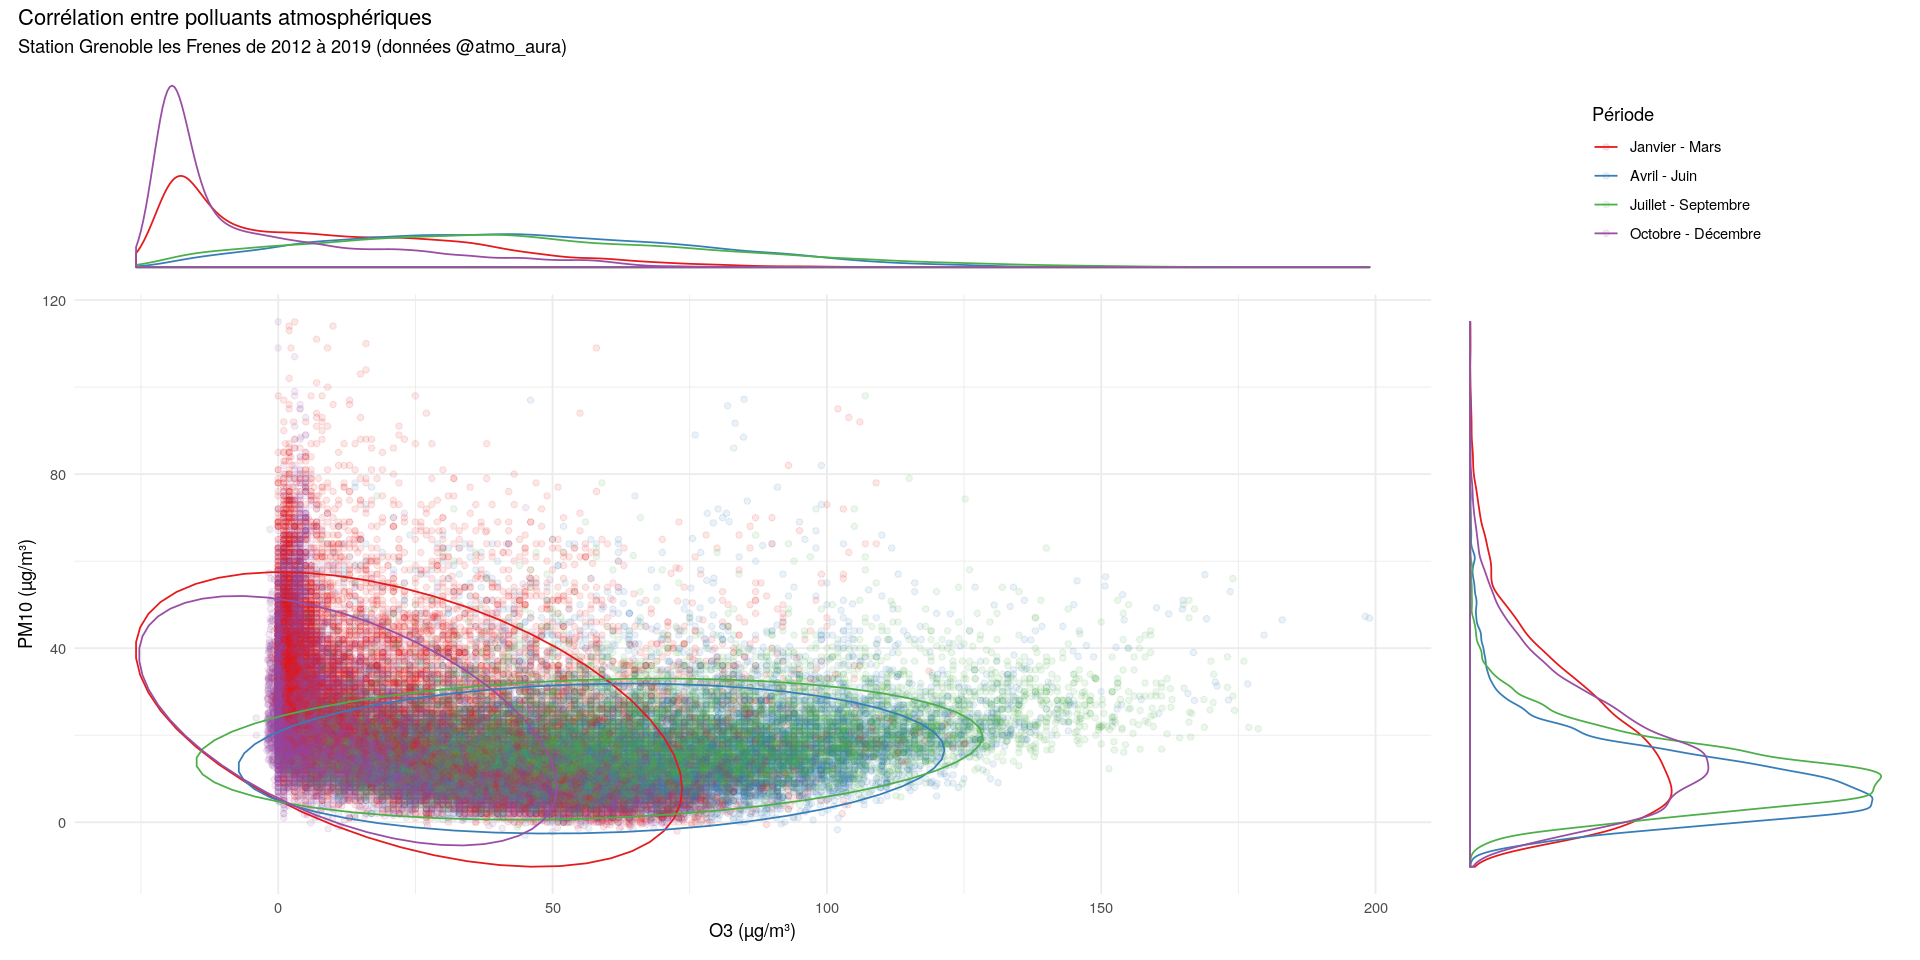

 chr "Correlation de 0.92 entre les taux de PM10 et PM2.5"


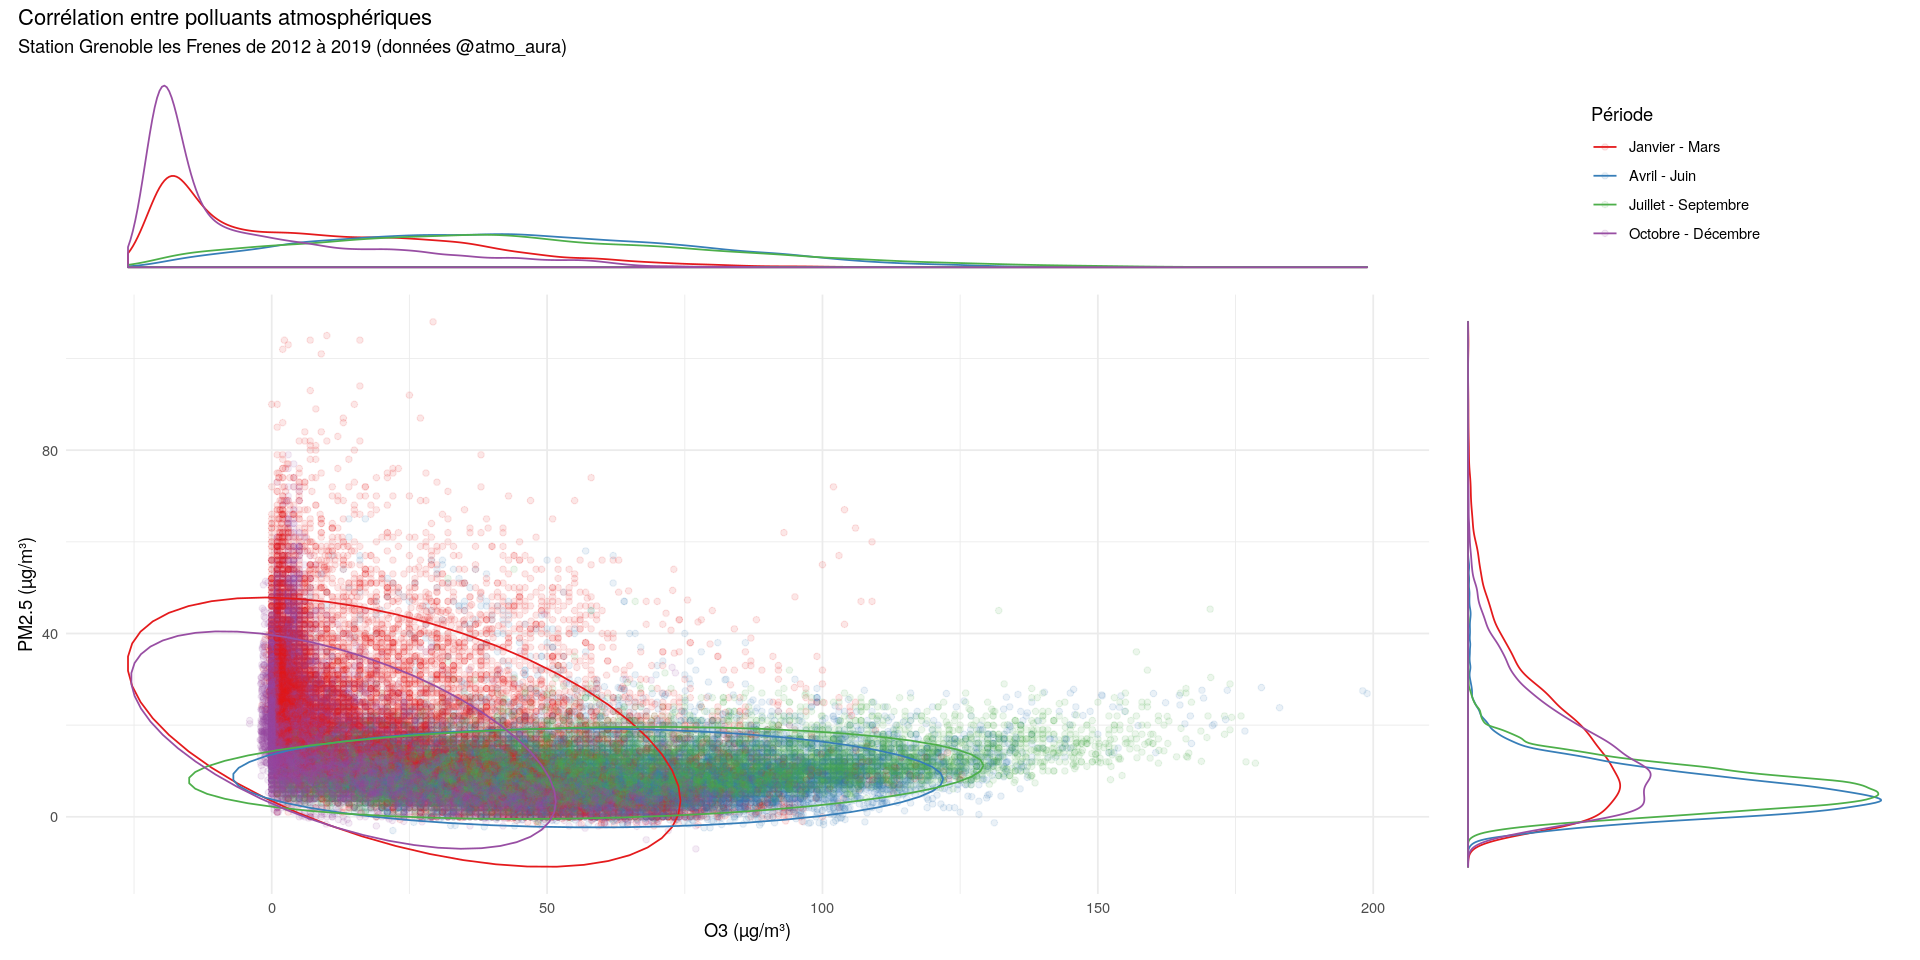

In [25]:
tmp = df %>%
    filter(Annee <= 2019, Station == "Grenoble les Frenes") %>%
    filter((raw_date != "05.10.2017.1.00")) %>%  # on supprime cette mesure anormalement haute, voir ci dessus
    group_by(Date, Annee, Station, Mesure) %>% summarise(Valeur = unique(Valeur)) %>%  # for some reason, January 1st at 00:00 is duplicated
    mutate(short_name = ifelse(
        Mesure == "Dioxyde d'azote", "NO2", ifelse(
        Mesure == "Monoxyde d'azote", "NO", ifelse(
        Mesure == "Ozone", "O3", ifelse(
        Mesure == "Particules PM10", "PM10", ifelse(
        Mesure == "Particules PM2.5", "PM2.5", "UNKNOWN")))))) %>%
    pivot_wider(id_cols = c(Date, Station, Annee), names_from = short_name, values_from = Valeur) %>%
    ungroup() %>%
    mutate(Annee = as.factor(Annee)) %>%
    drop_na() %>%
    mutate(Mois=month(Date), Jour=day(Date), NumeroJour=yday(Date), NumeroSemaine=week(Date)) %>%
    mutate(Saison = (Mois+2)%/%3) %>%
    mutate(Saison = ifelse(
        Saison == 1, "Janvier - Mars", ifelse(
        Saison == 2, "Avril - Juin", ifelse (
        Saison == 3, "Juillet - Septembre", ifelse(
        Saison == 4, "Octobre - Décembre", "UNKNOWN"))))) %>%
    mutate(Saison = factor(Saison, levels=c("Janvier - Mars", "Avril - Juin", "Juillet - Septembre", "Octobre - Décembre")))

cols = c("NO2", "NO", "O3", "PM10", "PM2.5")
for(i in 1:(length(cols)-1)) {
    for(j in (i+1):length(cols)) {
        x = cols[[i]]
        y = cols[[j]]
        plot = plot_bivariate(tmp, x_col=x, y_col=y, group_col="Saison")
        print(plot)
    }
}

## Couples O3/NO2

D'après [Wikipedia](https://fr.wikipedia.org/wiki/Ozone_troposph%C3%A9rique#Origine), l'ozone de la troposphère est produit principalement par une réaction chimique impliquant le dioxyde d'azote :

$$\text{NO}_2 + \text{O}_2 \rightarrow \text{NO} + \text{O}_3$$

La réaction inverse est également possible :

$$\text{NO} + \text{O}_3 \rightarrow \text{NO}_2 + O_2$$

On peut notamment voir un signe de cette réaction sur les figures ci dessus, il y a une corrélation négative entre le taux d'ozone et le taux de dioxyde d'azote.

Ainsi, une hausse (resp. une baisse) du taux de l'un de ces polluants peut être simplement dûe à la baisse (resp. la hausse) de l'autre polluant. Si l'on souhaite avoir un meilleur apperçu des effets éventuels des politiques de lutte contre la pollution, visualiser l'évolution au cours du temps d'un seul de ces polluant est donc insuffisant : il faut plutôt visualiser la somme.

D'après la formule ci dessus, une mollécule de dioxyde d'azote correspond à une mollécule d'ozone. On pourrait donc sommer les taux observés pour ces deux polluants, mais ce serait une approximation. Ces deux mollécules n'ont pas la même masse molaire, donc un gramme de dioxyde d'azote ne vas pas donner un gramme d'ozone. Si on veut faire une somme, il faut donc plutôt compter en termes de quantité de mollécules, soit en moles.

Pour faire la conversion :
- Masse molaire de NO2: 46.0055g/mol (voir [Wikipedia](https://fr.wikipedia.org/wiki/Dioxyde_d%27azote))
- Masse molaire de O3: 47.9982g/mol (voir [Wikipedia](https://fr.wikipedia.org/wiki/Ozone))

In [26]:
width = 24*7
tmp = df %>%
    filter(Station == "Grenoble les Frenes", Mesure %in% c("Dioxyde d'azote", "Ozone")) %>%
    group_by(Date, Annee, Station, Mesure) %>% summarise(Valeur = unique(Valeur)) %>%  # for some reason, January 1st at 00:00 is duplicated
    mutate(short_name = ifelse(
        Mesure == "Dioxyde d'azote", "NO2", ifelse(
        Mesure == "Ozone", "O3", "UNKNOWN"))) %>%
    pivot_wider(id_cols = c(Date, Station, Annee), names_from = short_name, values_from = Valeur) %>%
    ungroup() %>%
    mutate(NO2_mol = NO2/46.0055, O3_mol = 03/47.9982, somme = NO2_mol + O3_mol) %>%
    mutate(avg=rollapply(somme, width, mean, fill=NA)) %>%
    drop_na() %>%
    mutate(NumeroSemaine=week(Date), Instant=parse_date_time(format(Date, format="%m/%d %H:%M"), "mdhM"))

tmp %>% head()

Date                Station             Annee NO2 O3 NO2_mol   O3_mol    
1 2012-01-08 02:00:00 Grenoble les Frenes 2012  40  0  0.8694613 0.06250234
2 2012-01-08 03:00:00 Grenoble les Frenes 2012  40  0  0.8694613 0.06250234
3 2012-01-08 04:00:00 Grenoble les Frenes 2012  39  0  0.8477247 0.06250234
4 2012-01-08 05:00:00 Grenoble les Frenes 2012  38  0  0.8259882 0.06250234
5 2012-01-08 06:00:00 Grenoble les Frenes 2012  35  0  0.7607786 0.06250234
6 2012-01-08 07:00:00 Grenoble les Frenes 2012  35  0  0.7607786 0.06250234
  somme     avg       NumeroSemaine Instant         
1 0.9319636 0.6282991 2             0-01-08 02:00:00
2 0.9319636 0.6302398 2             0-01-08 03:00:00
3 0.9102271 0.6326981 2             0-01-08 04:00:00
4 0.8884905 0.6364503 2             0-01-08 05:00:00
5 0.8232809 0.6416256 2             0-01-08 06:00:00
6 0.8232809 0.6464129 2             0-01-08 07:00:00

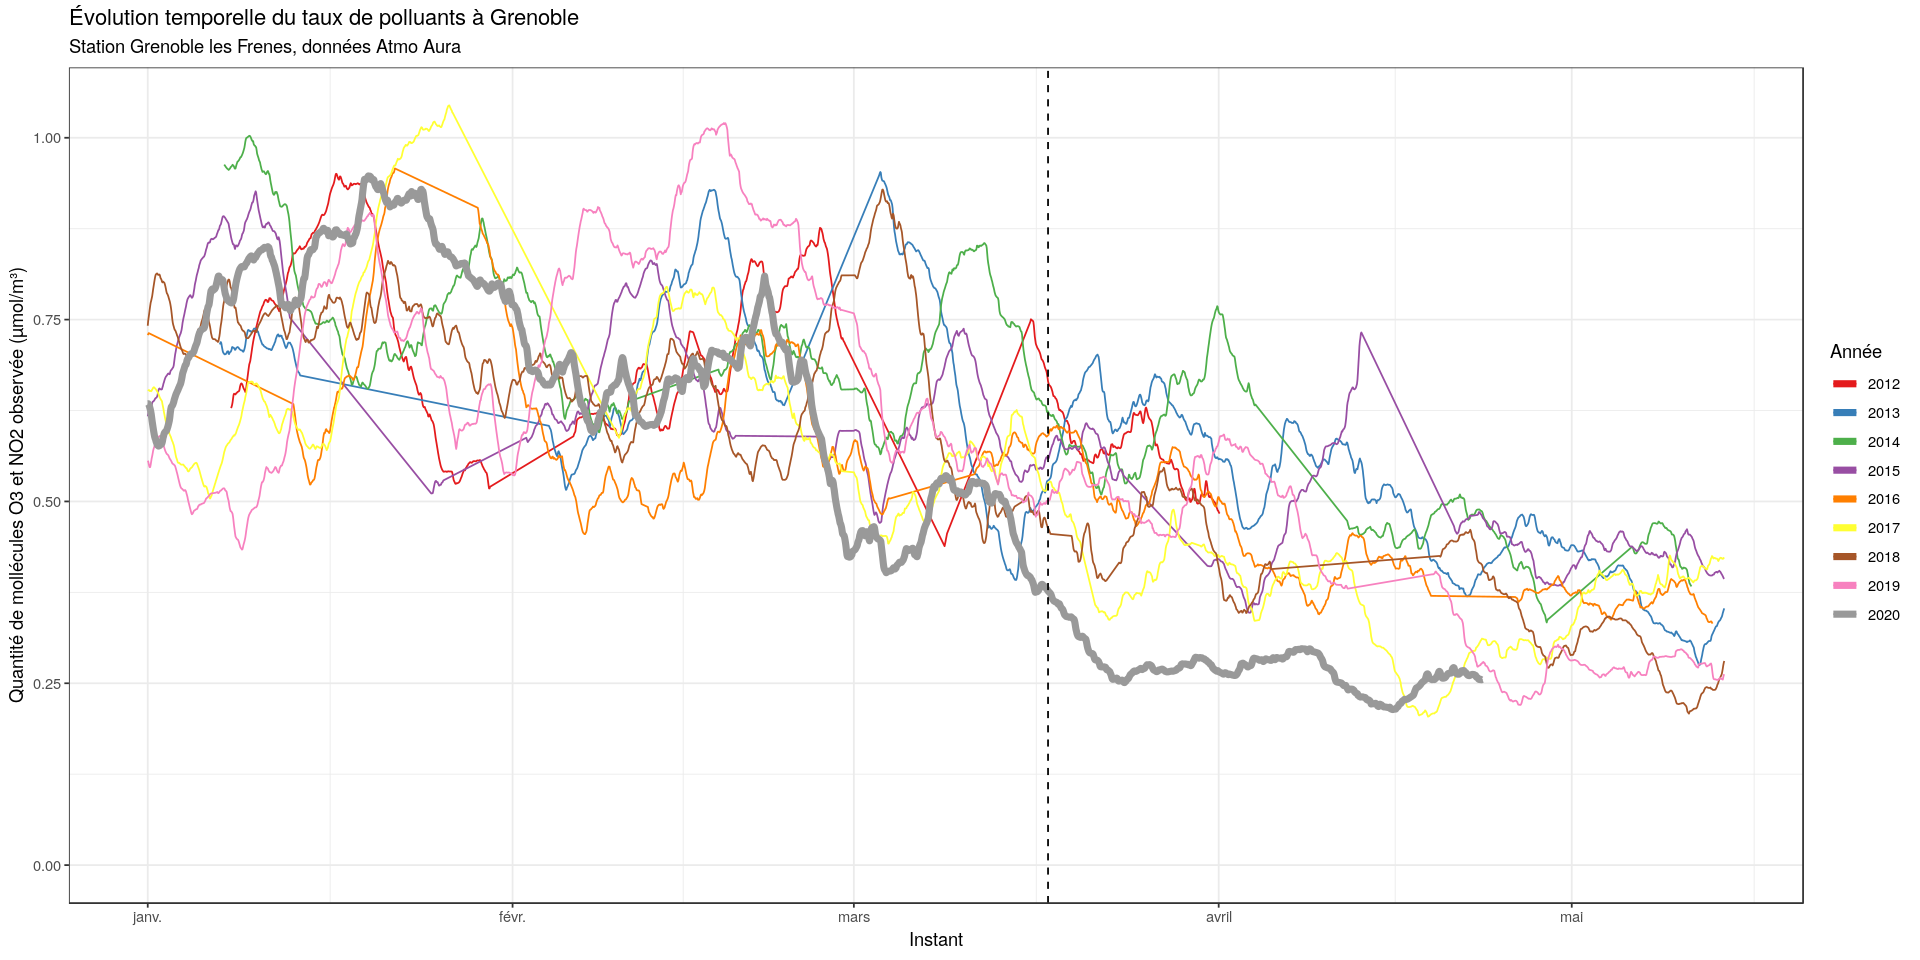

In [27]:
tmp %>%
    filter(NumeroSemaine < max_numero_semaine + 3) %>% {
    ggplot(.) +
    aes(x=Instant, y=avg, color=factor(Annee)) +
    geom_line() +
    geom_line(data=filter(., Annee == 2020), size=2) +
    theme_bw() +
    expand_limits(y=0) +
    scale_colour_brewer(palette = "Set1") +
    geom_vline(xintercept=parse_date_time("17/03 12:00", "dmhM"), linetype='dashed') +
    ylab("Quantité de mollécules O3 et NO2 observée (µmol/m³)") +
    labs(color='Année') +
    ggtitle("Évolution temporelle du taux de polluants à Grenoble") +
    labs(subtitle="Station Grenoble les Frenes, données Atmo Aura")
}

## Conclusion

- Pas de différence importante concernant les particules fines (PM10 ou PM2.5) et l'ozone.
- Une chute notable du dioxyde d'azote et du monoxyde d'azote (respectivement environ -50% et -70%).